In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


S_P_500 = pd.read_csv('Data/bitcoin without lag.csv')
S_P_data = S_P_500.reset_index(drop=True)

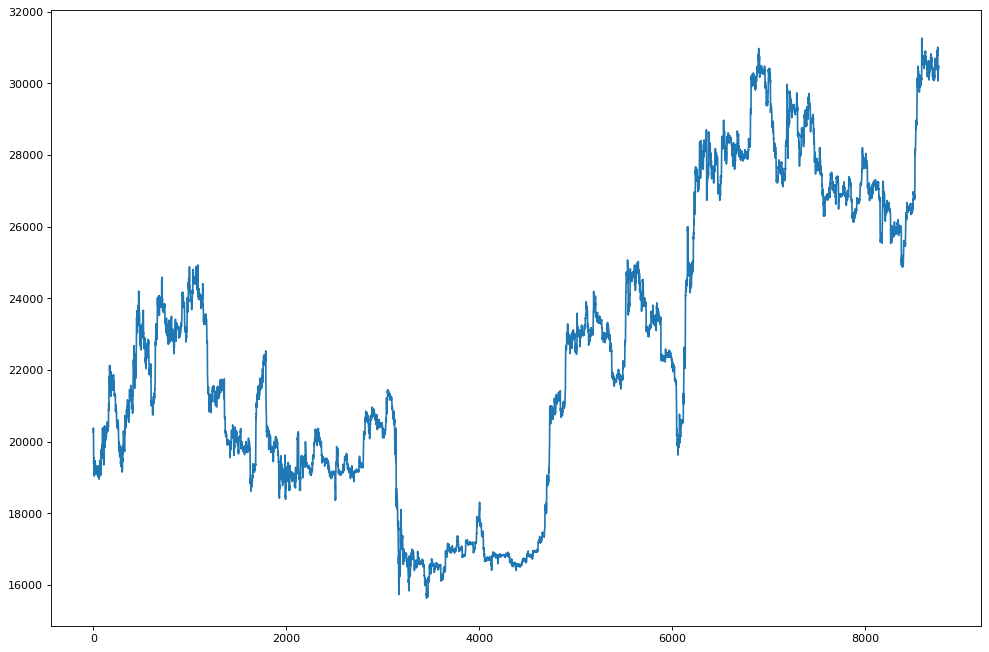

In [29]:
# Time series plot of S&P 500 data
figure(figsize=(15, 10), dpi=80)
time_x = S_P_data.index
time_y = S_P_data['close']
plt.plot(time_x,time_y)
plt.show()

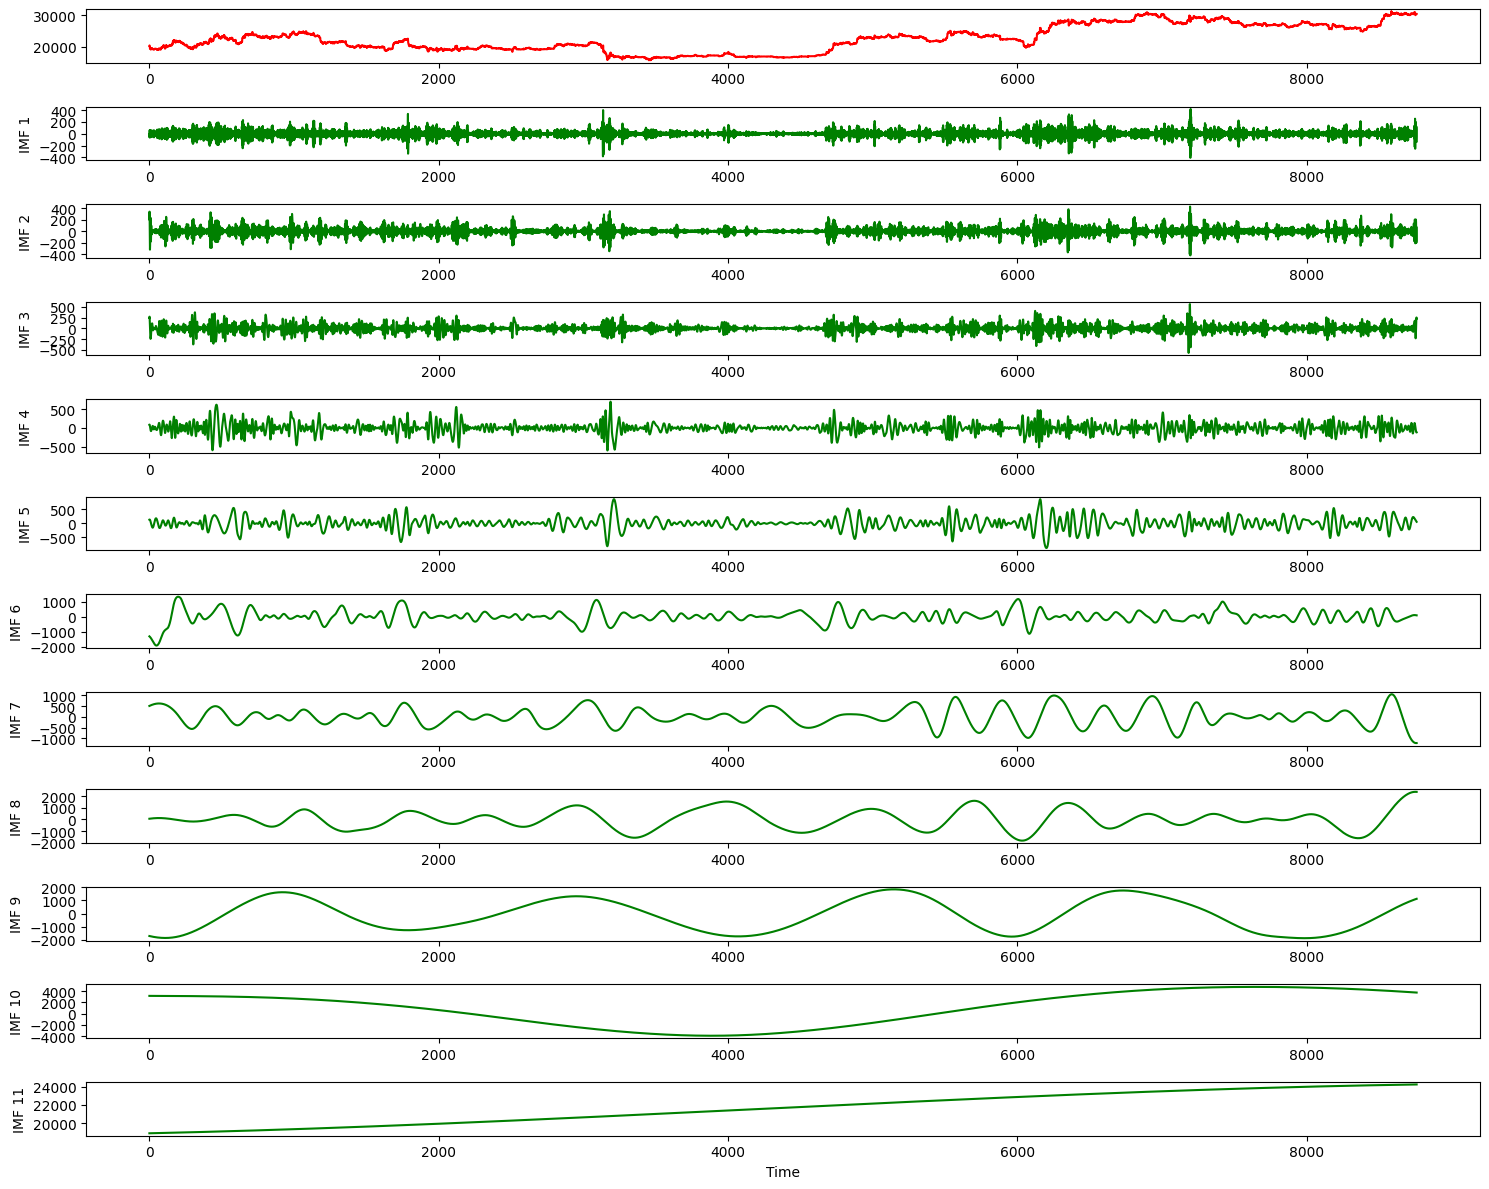

In [30]:
Signal = S_P_data['close'].to_numpy()
T = S_P_data.index.to_numpy()
from PyEMD import EMD
emd = EMD()
IMFs = emd(Signal)
nIMFs = len(IMFs)

# visualize the subsequences getting from the original signal
plt.figure(figsize = (15,12))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(T, Signal, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs + 1, 1, n + 2)
    plt.plot(T, IMFs[n], 'g')
    plt.ylabel("IMF %i" %(n + 1))
    plt.locator_params(axis = 'y', nbins=5)

plt.xlabel("Time")
plt.tight_layout()
plt.savefig('eemd_example', dpi = 120)
plt.show()

In [31]:
# Create dataset by looking specific number of steps back
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [32]:
# MAPE
import statistics
from sklearn.metrics import mean_squared_error

def MAPE(actual, pred):
    assert len(actual) == len(pred), "Input arrays must have the same length."
    error_ = []
    for ii in range(len(actual)):
        absolute_errors = abs((actual[ii] - pred[ii]) / actual[ii])
        error_.append(absolute_errors)
    
    mape = (sum(error_)/len(error_)) * 100.0

    return mape

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [33]:
def perform_LSTM(dataset, look_back, layer = 4, epochs = 100, batch_size = 16):
  
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))

    # Normalize the data -- using Min and Max values in each subsequence to normalize the values
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)

    # Split data into training and testing set
    train_size = len(dataset) - 500
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:, :]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(layer, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = 2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    testing_error = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

    return testPredict, testY, testing_error

In [ ]:
IMF_predict_list = []
error_list = []
for IMF in IMFs:
    iter_ = len(error_list) + 1
    print(f'========================================Training for IMF: {iter_}========================================')
    IMF_predict, IMF_test, testing_error = perform_LSTM(IMF, 10, layer = 4, epochs = 100, batch_size = 32)
    error_list.append(testing_error)
    IMF_predict_list.append(IMF_predict)
    print('')

========================================Training for IMF: 1========================================
Epoch 1/100
258/258 - 2s - loss: 0.0307 - 2s/epoch - 8ms/step
Epoch 2/100
258/258 - 1s - loss: 0.0052 - 1s/epoch - 4ms/step
Epoch 3/100
258/258 - 1s - loss: 0.0052 - 1s/epoch - 4ms/step
Epoch 4/100
258/258 - 1s - loss: 0.0051 - 997ms/epoch - 4ms/step
Epoch 5/100
258/258 - 1s - loss: 0.0051 - 966ms/epoch - 4ms/step
Epoch 6/100
258/258 - 1s - loss: 0.0050 - 1s/epoch - 4ms/step
Epoch 7/100
258/258 - 1s - loss: 0.0050 - 981ms/epoch - 4ms/step
Epoch 8/100
258/258 - 1s - loss: 0.0049 - 975ms/epoch - 4ms/step
Epoch 9/100
258/258 - 1s - loss: 0.0049 - 973ms/epoch - 4ms/step
Epoch 10/100
258/258 - 1s - loss: 0.0048 - 986ms/epoch - 4ms/step
Epoch 11/100
258/258 - 1s - loss: 0.0048 - 1s/epoch - 4ms/step
Epoch 12/100
258/258 - 1s - loss: 0.0048 - 1s/epoch - 4ms/step
Epoch 13/100
258/258 - 1s - loss: 0.0048 - 937ms/epoch - 4ms/step
Epoch 14/100
258/258 - 1s - loss: 0.0047 - 1s/epoch - 4ms/step
Epoch 

Epoch 25/100
258/258 - 1s - loss: 0.0013 - 1s/epoch - 4ms/step
Epoch 26/100
258/258 - 1s - loss: 0.0013 - 986ms/epoch - 4ms/step
Epoch 27/100
258/258 - 1s - loss: 0.0013 - 991ms/epoch - 4ms/step
Epoch 28/100
258/258 - 1s - loss: 0.0012 - 1s/epoch - 4ms/step
Epoch 29/100
258/258 - 1s - loss: 0.0012 - 1s/epoch - 4ms/step
Epoch 30/100
258/258 - 1s - loss: 0.0012 - 994ms/epoch - 4ms/step
Epoch 31/100
258/258 - 1s - loss: 0.0012 - 996ms/epoch - 4ms/step
Epoch 32/100
258/258 - 1s - loss: 0.0012 - 1s/epoch - 4ms/step
Epoch 33/100
258/258 - 1s - loss: 0.0012 - 988ms/epoch - 4ms/step
Epoch 34/100
258/258 - 1s - loss: 0.0012 - 980ms/epoch - 4ms/step
Epoch 35/100
258/258 - 1s - loss: 0.0012 - 978ms/epoch - 4ms/step
Epoch 36/100
258/258 - 1s - loss: 0.0012 - 1s/epoch - 4ms/step
Epoch 37/100
258/258 - 1s - loss: 0.0012 - 973ms/epoch - 4ms/step
Epoch 38/100
258/258 - 1s - loss: 0.0012 - 1s/epoch - 4ms/step
Epoch 39/100
258/258 - 1s - loss: 0.0012 - 982ms/epoch - 4ms/step
Epoch 40/100
258/258 - 1s - 

Epoch 46/100
258/258 - 1s - loss: 1.6396e-04 - 948ms/epoch - 4ms/step
Epoch 47/100
258/258 - 1s - loss: 1.5959e-04 - 958ms/epoch - 4ms/step
Epoch 48/100
258/258 - 1s - loss: 1.5710e-04 - 985ms/epoch - 4ms/step
Epoch 49/100
258/258 - 1s - loss: 1.5655e-04 - 991ms/epoch - 4ms/step
Epoch 50/100
258/258 - 1s - loss: 1.5535e-04 - 988ms/epoch - 4ms/step
Epoch 51/100
258/258 - 1s - loss: 1.5358e-04 - 1s/epoch - 4ms/step
Epoch 52/100
258/258 - 1s - loss: 1.5061e-04 - 1s/epoch - 4ms/step
Epoch 53/100
258/258 - 1s - loss: 1.4735e-04 - 957ms/epoch - 4ms/step
Epoch 54/100
258/258 - 1s - loss: 1.4503e-04 - 984ms/epoch - 4ms/step
Epoch 55/100
258/258 - 1s - loss: 1.4541e-04 - 971ms/epoch - 4ms/step
Epoch 56/100
258/258 - 1s - loss: 1.4250e-04 - 1s/epoch - 4ms/step
Epoch 57/100
258/258 - 1s - loss: 1.4401e-04 - 997ms/epoch - 4ms/step
Epoch 58/100
258/258 - 1s - loss: 1.4030e-04 - 969ms/epoch - 4ms/step
Epoch 59/100
258/258 - 1s - loss: 1.4110e-04 - 962ms/epoch - 4ms/step
Epoch 60/100
258/258 - 1s - l

Epoch 63/100
258/258 - 1s - loss: 1.5988e-05 - 989ms/epoch - 4ms/step
Epoch 64/100
258/258 - 1s - loss: 1.5899e-05 - 1s/epoch - 4ms/step
Epoch 65/100
258/258 - 1s - loss: 1.5385e-05 - 1s/epoch - 4ms/step
Epoch 66/100
258/258 - 1s - loss: 1.5203e-05 - 1s/epoch - 4ms/step
Epoch 67/100
258/258 - 1s - loss: 1.4568e-05 - 1s/epoch - 4ms/step
Epoch 68/100
258/258 - 1s - loss: 1.4911e-05 - 1s/epoch - 4ms/step
Epoch 69/100
258/258 - 1s - loss: 1.4996e-05 - 1s/epoch - 4ms/step
Epoch 70/100
258/258 - 1s - loss: 1.4324e-05 - 983ms/epoch - 4ms/step
Epoch 71/100
258/258 - 1s - loss: 1.3191e-05 - 998ms/epoch - 4ms/step
Epoch 72/100
258/258 - 1s - loss: 1.3665e-05 - 955ms/epoch - 4ms/step
Epoch 73/100
258/258 - 1s - loss: 1.3263e-05 - 988ms/epoch - 4ms/step
Epoch 74/100
258/258 - 1s - loss: 1.3091e-05 - 1s/epoch - 4ms/step
Epoch 75/100
258/258 - 1s - loss: 1.3660e-05 - 995ms/epoch - 4ms/step
Epoch 76/100
258/258 - 1s - loss: 1.2505e-05 - 1s/epoch - 4ms/step
Epoch 77/100
258/258 - 1s - loss: 1.2414e-05

Epoch 81/100
258/258 - 1s - loss: 5.3460e-06 - 961ms/epoch - 4ms/step
Epoch 82/100
258/258 - 1s - loss: 4.7576e-06 - 969ms/epoch - 4ms/step
Epoch 83/100
258/258 - 1s - loss: 5.1720e-06 - 956ms/epoch - 4ms/step
Epoch 84/100
258/258 - 1s - loss: 4.7091e-06 - 956ms/epoch - 4ms/step
Epoch 85/100
258/258 - 1s - loss: 5.0859e-06 - 992ms/epoch - 4ms/step
Epoch 86/100
258/258 - 1s - loss: 4.9077e-06 - 978ms/epoch - 4ms/step
Epoch 87/100
258/258 - 1s - loss: 4.8628e-06 - 1s/epoch - 4ms/step
Epoch 88/100
258/258 - 1s - loss: 4.6794e-06 - 1s/epoch - 4ms/step
Epoch 89/100
258/258 - 1s - loss: 5.9920e-06 - 998ms/epoch - 4ms/step
Epoch 90/100
258/258 - 1s - loss: 4.7553e-06 - 1s/epoch - 4ms/step
Epoch 91/100
258/258 - 1s - loss: 4.5227e-06 - 993ms/epoch - 4ms/step
Epoch 92/100
258/258 - 1s - loss: 4.7959e-06 - 991ms/epoch - 4ms/step
Epoch 93/100
258/258 - 1s - loss: 5.0494e-06 - 983ms/epoch - 4ms/step
Epoch 94/100
258/258 - 1s - loss: 4.3588e-06 - 1s/epoch - 4ms/step
Epoch 95/100
258/258 - 1s - loss

Epoch 99/100
258/258 - 1s - loss: 4.9918e-06 - 1s/epoch - 4ms/step
Epoch 100/100
258/258 - 1s - loss: 4.7627e-06 - 1s/epoch - 4ms/step
16/16 [==============================] - 0s 2ms/step

========================================Training for IMF: 7========================================
Epoch 1/100
258/258 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 2/100
258/258 - 1s - loss: 0.0034 - 1s/epoch - 4ms/step
Epoch 3/100
258/258 - 1s - loss: 0.0016 - 1s/epoch - 4ms/step
Epoch 4/100
258/258 - 1s - loss: 7.1257e-04 - 998ms/epoch - 4ms/step
Epoch 5/100
258/258 - 1s - loss: 4.3413e-04 - 956ms/epoch - 4ms/step
Epoch 6/100
258/258 - 1s - loss: 3.6930e-04 - 973ms/epoch - 4ms/step
Epoch 7/100
258/258 - 1s - loss: 3.4872e-04 - 1s/epoch - 4ms/step
Epoch 8/100
258/258 - 1s - loss: 3.3219e-04 - 981ms/epoch - 4ms/step
Epoch 9/100
258/258 - 1s - loss: 3.1545e-04 - 973ms/epoch - 4ms/step
Epoch 10/100
258/258 - 1s - loss: 2.9887e-04 - 983ms/epoch - 4ms/step
Epoch 11/100
258/258 - 1s - loss: 2.8006e-04

258/258 - 1s - loss: 8.9787e-05 - 894ms/epoch - 3ms/step
Epoch 12/100
258/258 - 1s - loss: 8.7956e-05 - 873ms/epoch - 3ms/step
Epoch 13/100
258/258 - 1s - loss: 8.5396e-05 - 847ms/epoch - 3ms/step
Epoch 14/100
258/258 - 1s - loss: 8.3909e-05 - 862ms/epoch - 3ms/step
Epoch 15/100
258/258 - 1s - loss: 8.2529e-05 - 849ms/epoch - 3ms/step
Epoch 16/100
258/258 - 1s - loss: 7.8296e-05 - 864ms/epoch - 3ms/step
Epoch 17/100
258/258 - 1s - loss: 7.5978e-05 - 850ms/epoch - 3ms/step
Epoch 18/100
258/258 - 1s - loss: 7.3512e-05 - 912ms/epoch - 4ms/step
Epoch 19/100
258/258 - 1s - loss: 6.9561e-05 - 868ms/epoch - 3ms/step
Epoch 20/100
258/258 - 1s - loss: 6.7860e-05 - 846ms/epoch - 3ms/step
Epoch 21/100
258/258 - 1s - loss: 6.2924e-05 - 971ms/epoch - 4ms/step
Epoch 22/100
258/258 - 1s - loss: 5.9096e-05 - 887ms/epoch - 3ms/step
Epoch 23/100
258/258 - 1s - loss: 5.7257e-05 - 881ms/epoch - 3ms/step
Epoch 24/100
258/258 - 1s - loss: 5.0794e-05 - 887ms/epoch - 3ms/step
Epoch 25/100
258/258 - 1s - loss:

In [22]:
for i in IMF_predict_list:
    i = i[:,0]

# This nested for loop is used to generate final prediction by adding up the corresponding values in each subsequence
final_prediction = []
for i in range(len(IMF_predict_list[0])):
    element = 0 
    for j in range(len(IMF_predict_list)):
        element += IMF_predict_list[j][i]
    final_prediction = final_prediction + element.tolist()

In [23]:
SP = time_y.astype('float32')
SP = np.reshape(SP.to_numpy(), (-1, 1))

train_size = int(len(SP) * 0.8)
test_size = len(SP) - train_size
SP_train, SP_test = SP[0:train_size], SP[train_size:]

SP_testX, SP_testY = create_dataset(SP_test, 10)

# Calculate the RMSE
rmse(mean_squared_error(SP_testY.tolist(), final_prediction)), MAPE(mean_squared_error(SP_testY.tolist(), final_prediction))

ValueError: Found input variables with inconsistent numbers of samples: [1741, 8249]

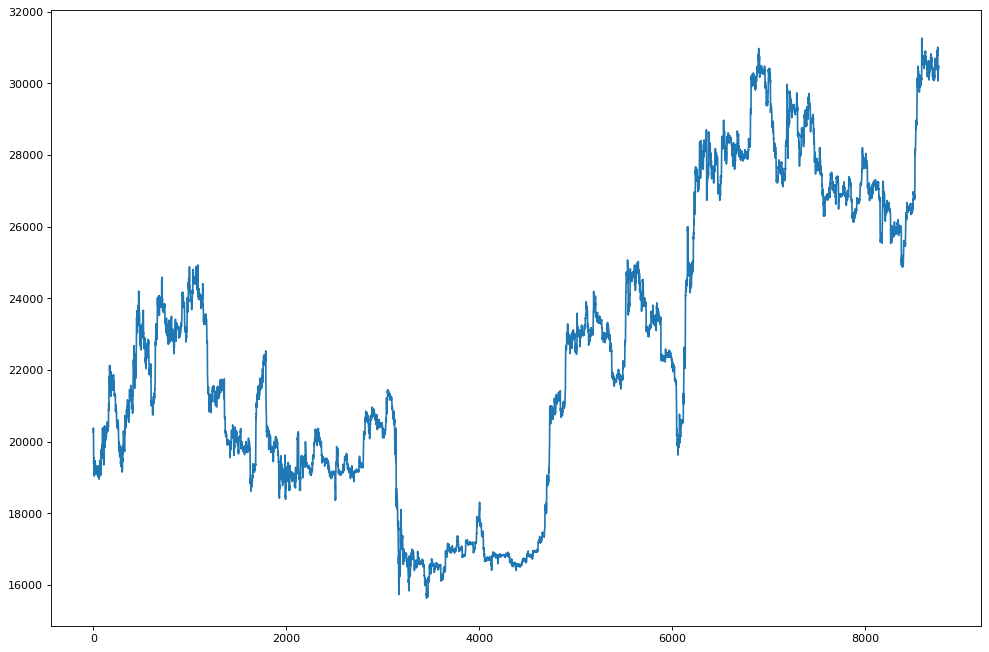

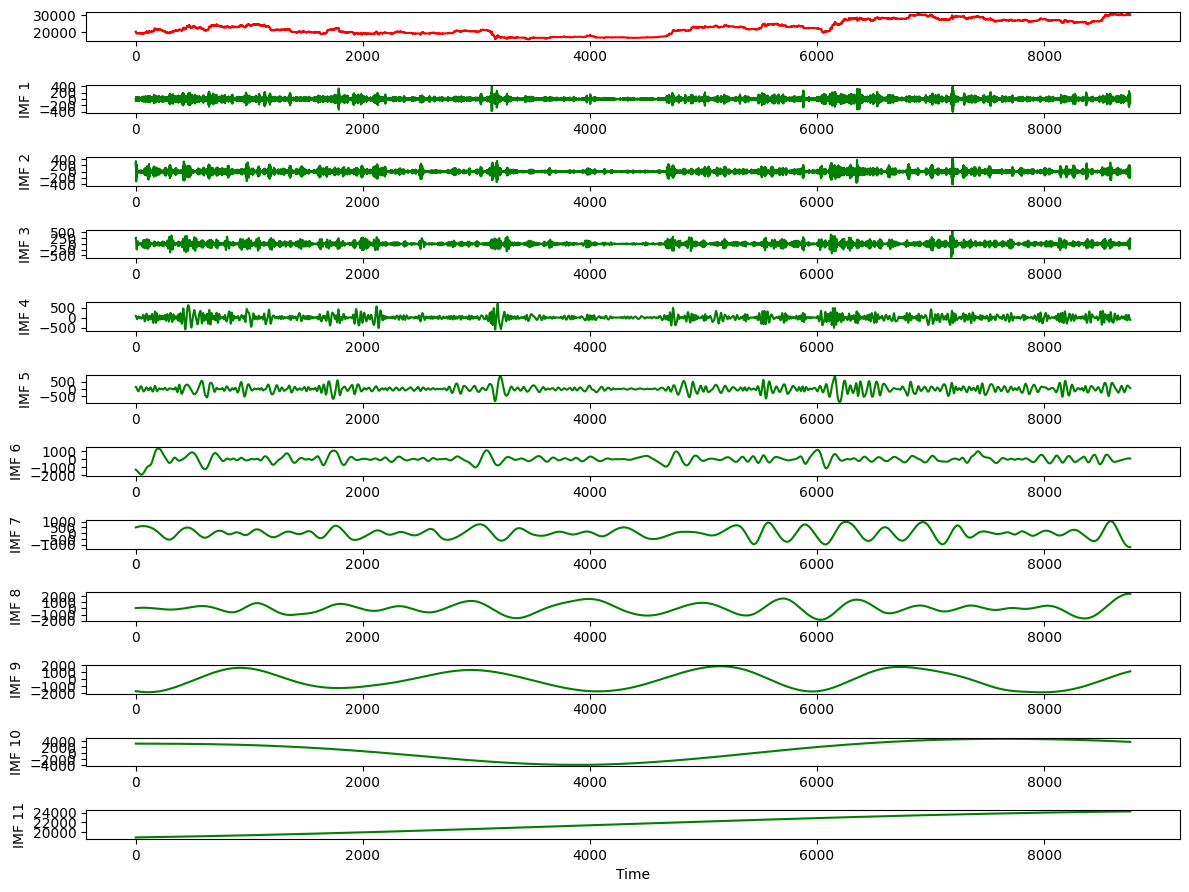

Epoch 1/100
6997/6997 - 30s - loss: 0.0065 - 30s/epoch - 4ms/step
Epoch 2/100
6997/6997 - 21s - loss: 0.0049 - 21s/epoch - 3ms/step
Epoch 3/100
6997/6997 - 21s - loss: 0.0048 - 21s/epoch - 3ms/step
Epoch 4/100
6997/6997 - 21s - loss: 0.0047 - 21s/epoch - 3ms/step
Epoch 5/100
6997/6997 - 21s - loss: 0.0047 - 21s/epoch - 3ms/step
Epoch 6/100
6997/6997 - 22s - loss: 0.0046 - 22s/epoch - 3ms/step
Epoch 7/100
6997/6997 - 21s - loss: 0.0046 - 21s/epoch - 3ms/step
Epoch 8/100
6997/6997 - 21s - loss: 0.0046 - 21s/epoch - 3ms/step
Epoch 9/100
6997/6997 - 22s - loss: 0.0046 - 22s/epoch - 3ms/step
Epoch 10/100
6997/6997 - 23s - loss: 0.0045 - 23s/epoch - 3ms/step
Epoch 11/100
6997/6997 - 21s - loss: 0.0045 - 21s/epoch - 3ms/step
Epoch 12/100
6997/6997 - 21s - loss: 0.0045 - 21s/epoch - 3ms/step
Epoch 13/100
6997/6997 - 21s - loss: 0.0045 - 21s/epoch - 3ms/step
Epoch 14/100
6997/6997 - 21s - loss: 0.0045 - 21s/epoch - 3ms/step
Epoch 15/100
6997/6997 - 21s - loss: 0.0045 - 21s/epoch - 3ms/step
Epoc

Epoch 22/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 23/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 24/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 25/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 26/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 27/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 28/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 29/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 30/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 31/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 32/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 33/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 34/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 35/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/step
Epoch 36/100
6997/6997 - 21s - loss: 0.0011 - 21s/epoch - 3ms/

Epoch 40/100
6997/6997 - 21s - loss: 1.0193e-04 - 21s/epoch - 3ms/step
Epoch 41/100
6997/6997 - 21s - loss: 1.0168e-04 - 21s/epoch - 3ms/step
Epoch 42/100
6997/6997 - 21s - loss: 9.7857e-05 - 21s/epoch - 3ms/step
Epoch 43/100
6997/6997 - 21s - loss: 1.0088e-04 - 21s/epoch - 3ms/step
Epoch 44/100
6997/6997 - 21s - loss: 1.0264e-04 - 21s/epoch - 3ms/step
Epoch 45/100
6997/6997 - 21s - loss: 9.7753e-05 - 21s/epoch - 3ms/step
Epoch 46/100
6997/6997 - 22s - loss: 9.5866e-05 - 22s/epoch - 3ms/step
Epoch 47/100
6997/6997 - 22s - loss: 9.6391e-05 - 22s/epoch - 3ms/step
Epoch 48/100
6997/6997 - 22s - loss: 9.6023e-05 - 22s/epoch - 3ms/step
Epoch 49/100
6997/6997 - 22s - loss: 9.5607e-05 - 22s/epoch - 3ms/step
Epoch 50/100
6997/6997 - 22s - loss: 9.4609e-05 - 22s/epoch - 3ms/step
Epoch 51/100
6997/6997 - 22s - loss: 9.4763e-05 - 22s/epoch - 3ms/step
Epoch 52/100
6997/6997 - 22s - loss: 9.1455e-05 - 22s/epoch - 3ms/step
Epoch 53/100
6997/6997 - 22s - loss: 9.5673e-05 - 22s/epoch - 3ms/step
Epoch 

6997/6997 - 21s - loss: 1.9323e-05 - 21s/epoch - 3ms/step
Epoch 55/100
6997/6997 - 21s - loss: 1.8503e-05 - 21s/epoch - 3ms/step
Epoch 56/100
6997/6997 - 21s - loss: 1.8109e-05 - 21s/epoch - 3ms/step
Epoch 57/100
6997/6997 - 22s - loss: 1.7253e-05 - 22s/epoch - 3ms/step
Epoch 58/100
6997/6997 - 22s - loss: 1.7798e-05 - 22s/epoch - 3ms/step
Epoch 59/100
6997/6997 - 21s - loss: 1.7583e-05 - 21s/epoch - 3ms/step
Epoch 60/100
6997/6997 - 21s - loss: 1.7393e-05 - 21s/epoch - 3ms/step
Epoch 61/100
6997/6997 - 22s - loss: 1.7229e-05 - 22s/epoch - 3ms/step
Epoch 62/100
6997/6997 - 22s - loss: 1.7559e-05 - 22s/epoch - 3ms/step
Epoch 63/100
6997/6997 - 21s - loss: 1.7343e-05 - 21s/epoch - 3ms/step
Epoch 64/100
6997/6997 - 21s - loss: 1.7577e-05 - 21s/epoch - 3ms/step
Epoch 65/100
6997/6997 - 21s - loss: 1.5796e-05 - 21s/epoch - 3ms/step
Epoch 66/100
6997/6997 - 21s - loss: 1.6551e-05 - 21s/epoch - 3ms/step
Epoch 67/100
6997/6997 - 21s - loss: 1.5643e-05 - 21s/epoch - 3ms/step
Epoch 68/100
6997/6

KeyboardInterrupt: 

In [10]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(1, len(final_prediction)+1, len(final_prediction), endpoint=True)
# plot lines
plt.plot(x, final_prediction, label = "Predicted Value")
plt.plot(x, SP_testY.tolist(), label = "Actual Value")
plt.legend()
plt.show()
# Based on the plot, we can find out that the predictions of higher frequency signals are better than the prediction of overall trend

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime as dt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.deterministic import DeterministicProcess
import pmdarima as pm

from tensorflow import keras
from keras import metrics, initializers
from tensorflow.keras.layers import Dropout,LSTM, GRU, BatchNormalization, Dense, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


from tensorflow.keras import callbacks
from keras.callbacks import ReduceLROnPlateau

from matplotlib import style
style.use('tableau-colorblind10')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import scipy as sp
import sympy as smp
from skimage import color
from skimage import io
from scipy.fft import fftfreq
from scipy.fft import fft, ifft, fft2, ifft2

In [4]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [5]:
df = pd.read_csv('Data/bitcoin without lag.csv', parse_dates=['datetime'], index_col=['datetime'])
#df = pd.read_csv('Data/Bitcoin preprocessed.csv', index_col=['datetime'])
df.head()

,high,low,open,volumefrom,volumeto,close,hourly_volume,top_tier_volume_quote,top_tier_volume_base,top_tier_volume_total,cccagg_volume_quote,cccagg_volume_base,cccagg_volume_total,total_volume_quote,total_volume_base,total_volume_total,eth_open,eth_close,bnb_open,bnb_close,usdt_open,usdt_close,sol_open,sol_close,hourly_return,3_hourly_return,5_hourly_return,12_hourly_return,3_hourly_volatility,5_hourly_volatility,12_hourly_volatility,daily_volatility,trend_score,Pos_score,Neg_score,Compound_score,Polarity,time_of_the_day,day,day_of_month,weekend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:00:00,20817.65,19647.29,19908.49,6823.65,1.381081e+08,20262.66,143641.30,1.413396e+08,1.734342e+09,1.875681e+09,1.023345e+08,1.014878e+09,1.117212e+09,1.706061e+08,1.915078e+09,2.085684e+09,1069.53,1093.82,219.48,222.58,0.9992,0.9987,33.74,34.44,354.17,1464.85,1379.49,1072.73,493.599288,460.540694,348.583077,286.091957,100.0,0.090867,0.064867,0.115550,0.0,0.0,Friday,1,0
2022-07-01 01:00:00,20444.21,20231.53,20262.66,3183.32,6.471331e+07,20380.14,64012.17,6.423249e+07,8.010797e+08,8.653122e+08,4.611965e+07,4.423495e+08,4.884692e+08,8.518715e+07,8.941570e+08,9.793442e+08,1093.82,1095.07,222.58,225.22,0.9987,0.9985,34.44,34.87,117.48,1506.73,1646.43,1531.40,476.384009,411.796784,321.143744,286.846382,113.0,0.098000,0.066744,0.034856,0.0,1.0,Friday,1,0
2022-07-01 02:00:00,20504.52,20238.04,20380.14,2262.26,4.603065e+07,20266.86,48773.36,4.844529e+07,5.490071e+08,5.974524e+08,3.446238e+07,3.276693e+08,3.621317e+08,7.538542e+07,6.256688e+08,7.010542e+08,1095.07,1091.22,225.22,225.60,0.9985,0.9982,34.87,34.77,-113.28,358.37,1469.05,1165.98,233.731269,446.529586,325.557403,287.855508,92.0,0.132773,0.042909,0.103223,0.0,2.0,Friday,1,0
2022-07-01 03:00:00,20276.63,19668.22,20266.86,3603.45,7.212081e+07,19703.32,65925.93,5.869008e+07,8.222572e+08,8.809473e+08,4.438665e+07,4.956181e+08,5.400048e+08,7.742932e+07,9.239673e+08,1.001397e+09,1091.22,1053.55,225.60,220.97,0.9982,0.9980,34.77,33.61,-563.54,-559.34,829.91,583.05,346.355426,592.302312,377.555379,310.682042,90.0,0.109960,0.044840,0.166612,0.0,3.0,Friday,1,0
2022-07-01 04:00:00,19713.40,19352.87,19703.32,3932.58,7.685356e+07,19376.97,84503.60,7.795704e+07,2.074082e+09,2.152039e+09,5.267009e+07,6.085733e+08,6.612434e+08,1.007285e+08,2.285414e+09,2.386143e+09,1053.55,1048.59,220.97,219.20,0.9980,0.9981,33.61,32.55,-326.35,-1003.17,-531.52,257.76,225.237648,360.433506,392.813183,317.146276,97.0,0.093640,0.058400,0.132120,0.0,4.0,Friday,1,0


In [6]:
df = df.drop(['Pos_score', 'Neg_score'], axis = 1)

### Feature Engineering

In [7]:
df['day'].unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

In [8]:
df['day_of_week'] = 1
for i in range(len(df.index)):
    if df['day'][i] == 'Sunday':
        df['day_of_week'][i] = 1
    elif df['day'][i] == 'Monday':
        df['day_of_week'][i] = 2
    elif df['day'][i] == 'Tuesday':
        df['day_of_week'][i] = 3
    elif df['day'][i] == 'Wednesday':
        df['day_of_week'][i] = 4
    elif df['day'][i] == 'Thursday':
        df['day_of_week'][i] = 5
    elif df['day'][i] == 'Friday':
        df['day_of_week'][i] = 6
    elif df['day'][i] == 'Saturday':
        df['day_of_week'][i] = 7

In [9]:
#df.drop('day', axis = 1, inplace = True)
df['hourly_return'] = 0
for i in range(1, len(df.index)):
    df['hourly_return'][i] = df['close'][i] - df['close'][i-1]

In [10]:
df.head()

,high,low,open,volumefrom,volumeto,close,hourly_volume,top_tier_volume_quote,top_tier_volume_base,top_tier_volume_total,cccagg_volume_quote,cccagg_volume_base,cccagg_volume_total,total_volume_quote,total_volume_base,total_volume_total,eth_open,eth_close,bnb_open,bnb_close,usdt_open,usdt_close,sol_open,sol_close,hourly_return,3_hourly_return,5_hourly_return,12_hourly_return,3_hourly_volatility,5_hourly_volatility,12_hourly_volatility,daily_volatility,trend_score,Compound_score,Polarity,time_of_the_day,day,day_of_month,weekend,day_of_week
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:00:00,20817.65,19647.29,19908.49,6823.65,1.381081e+08,20262.66,143641.30,1.413396e+08,1.734342e+09,1.875681e+09,1.023345e+08,1.014878e+09,1.117212e+09,1.706061e+08,1.915078e+09,2.085684e+09,1069.53,1093.82,219.48,222.58,0.9992,0.9987,33.74,34.44,0.00,1464.85,1379.49,1072.73,493.599288,460.540694,348.583077,286.091957,100.0,0.115550,0.0,0.0,Friday,1,0,6
2022-07-01 01:00:00,20444.21,20231.53,20262.66,3183.32,6.471331e+07,20380.14,64012.17,6.423249e+07,8.010797e+08,8.653122e+08,4.611965e+07,4.423495e+08,4.884692e+08,8.518715e+07,8.941570e+08,9.793442e+08,1093.82,1095.07,222.58,225.22,0.9987,0.9985,34.44,34.87,117.48,1506.73,1646.43,1531.40,476.384009,411.796784,321.143744,286.846382,113.0,0.034856,0.0,1.0,Friday,1,0,6
2022-07-01 02:00:00,20504.52,20238.04,20380.14,2262.26,4.603065e+07,20266.86,48773.36,4.844529e+07,5.490071e+08,5.974524e+08,3.446238e+07,3.276693e+08,3.621317e+08,7.538542e+07,6.256688e+08,7.010542e+08,1095.07,1091.22,225.22,225.60,0.9985,0.9982,34.87,34.77,-113.28,358.37,1469.05,1165.98,233.731269,446.529586,325.557403,287.855508,92.0,0.103223,0.0,2.0,Friday,1,0,6
2022-07-01 03:00:00,20276.63,19668.22,20266.86,3603.45,7.212081e+07,19703.32,65925.93,5.869008e+07,8.222572e+08,8.809473e+08,4.438665e+07,4.956181e+08,5.400048e+08,7.742932e+07,9.239673e+08,1.001397e+09,1091.22,1053.55,225.60,220.97,0.9982,0.9980,34.77,33.61,-563.54,-559.34,829.91,583.05,346.355426,592.302312,377.555379,310.682042,90.0,0.166612,0.0,3.0,Friday,1,0,6
2022-07-01 04:00:00,19713.40,19352.87,19703.32,3932.58,7.685356e+07,19376.97,84503.60,7.795704e+07,2.074082e+09,2.152039e+09,5.267009e+07,6.085733e+08,6.612434e+08,1.007285e+08,2.285414e+09,2.386143e+09,1053.55,1048.59,220.97,219.20,0.9980,0.9981,33.61,32.55,-326.35,-1003.17,-531.52,257.76,225.237648,360.433506,392.813183,317.146276,97.0,0.132120,0.0,4.0,Friday,1,0,6


## Univariate Methods

In [11]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
target = df['close'].copy()
ts_decomposition = seasonal_decompose(x = target, model = 'additive', period = 2, extrapolate_trend = 'freq')
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

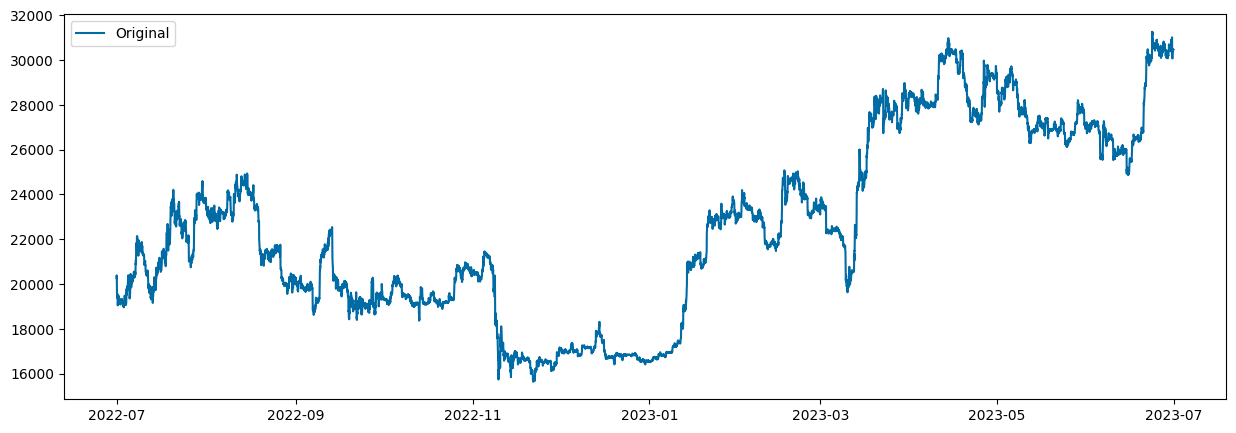

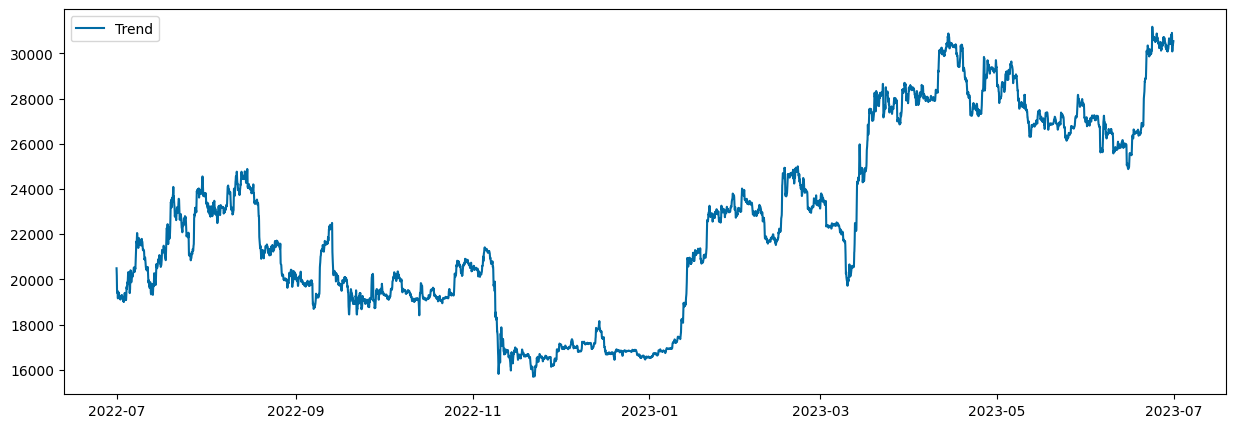

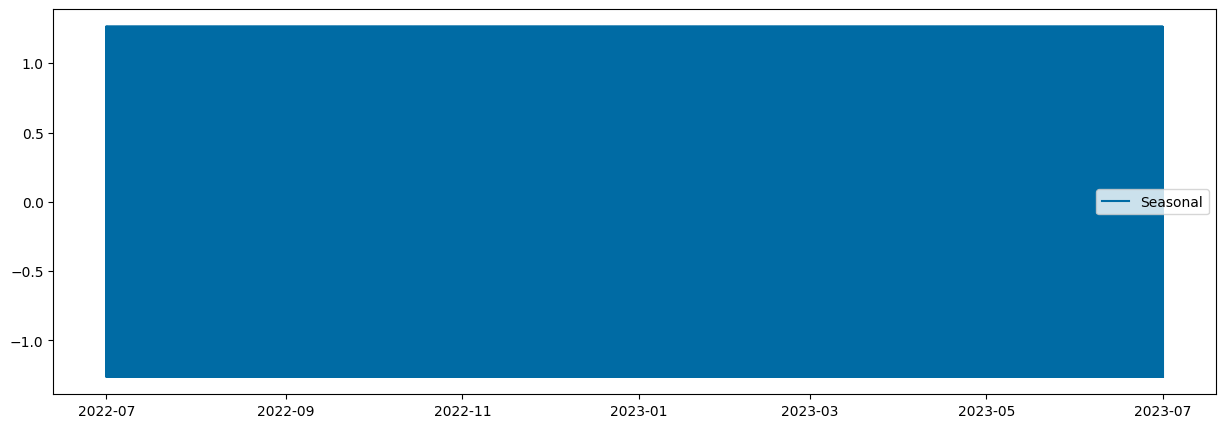

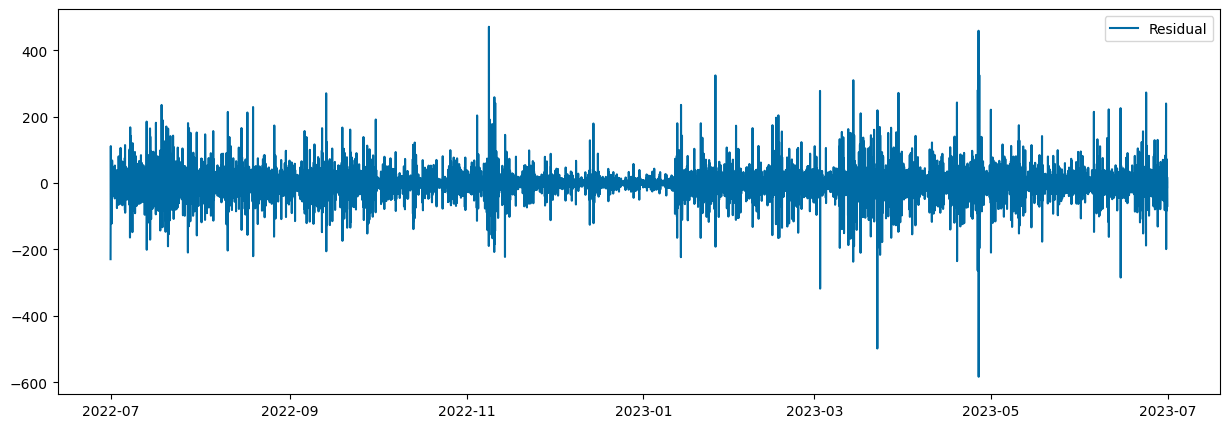

In [12]:
plt.figure(figsize=(15,5))
plt.plot(target, label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [13]:
new_df = df[['close']]
new_df['trend'] = trend_estimate
new_df['seasonal'] = seasonal_estimate
new_df['resid'] = residual_estimate

In [14]:
new_df

,close,trend,seasonal,resid
datetime,,,,
2022-07-01 00:00:00,20262.66,20490.6050,1.263217,-229.208217
2022-07-01 01:00:00,20380.14,20322.4500,-1.263217,58.953217
2022-07-01 02:00:00,20266.86,20154.2950,1.263217,111.301783
2022-07-01 03:00:00,19703.32,19762.6175,-1.263217,-58.034283
2022-07-01 04:00:00,19376.97,19472.5525,1.263217,-96.845717
...,...,...,...,...
2023-06-30 19:00:00,30376.79,30374.7975,-1.263217,3.255717
2023-06-30 20:00:00,30394.62,30408.8600,1.263217,-15.503217
2023-06-30 21:00:00,30469.41,30452.8600,-1.263217,17.813217


In [81]:
new_df['close'] = new_df['close'].shift(-1)
new_df = new_df.dropna()

In [82]:
trend = new_df['trend'].values
seasonal = new_df['seasonal'].values
resid = new_df['resid'].values
y = new_df['close'].values

trend_X_train, trend_X_test, y_train, y_test = train_test_split(trend, y, test_size = 500, shuffle = False)
resid_X_train, resid_X_test = train_test_split(resid, test_size = 500, shuffle = False)
seasonal_X_train, seasonal_X_test = train_test_split(seasonal, test_size = 500, shuffle = False)

trend_X_train = trend_X_train.reshape(-1, 1)
trend_X_test = trend_X_test.reshape(-1, 1)
resid_X_train = resid_X_train.reshape(-1, 1)
resid_X_test = resid_X_test.reshape(-1, 1)
seasonal_X_train = seasonal_X_train.reshape(-1, 1)
seasonal_X_test = seasonal_X_test.reshape(-1, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [83]:
# Fit trend model
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(trend_X_train, y_train)

LinearRegression(fit_intercept=False)

In [84]:
y_fit = model.predict(trend_X_train)
y_pred = model.predict(trend_X_test)

In [85]:
y_pred.shape

(500, 1)

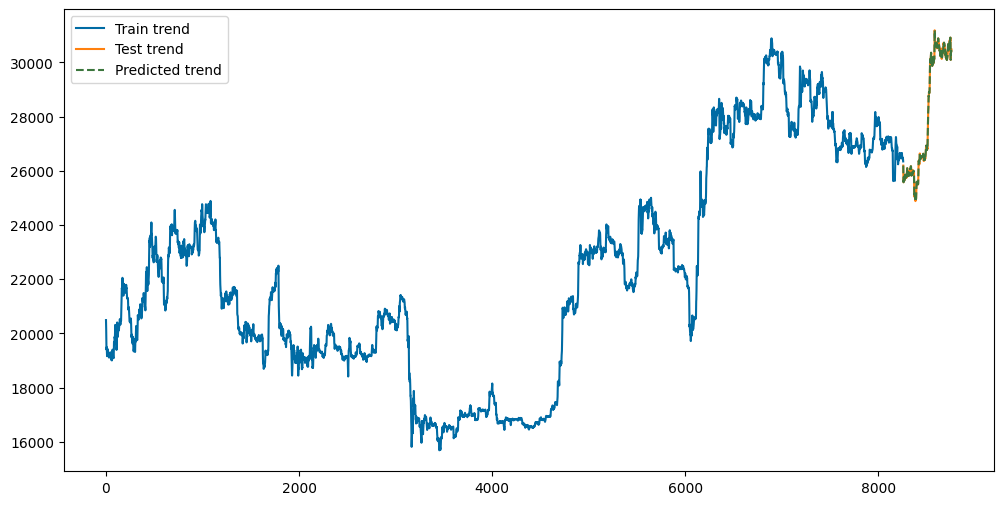

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, len(new_df.index) - 500), trend_X_train[:len(new_df.index) - 500], label = 'Train trend');
ax.plot(np.arange(len(new_df.index) - 500, len(new_df.index)), trend_X_test, label = 'Test trend');
#ax.plot(np.arange(0, len(df.index) - 500), y_fit, linestyle='--', color='#ff7823');
ax.plot(np.arange(len(new_df.index) - 500, len(new_df.index)), y_pred, linestyle='--', color='#3c763d', label = 'Predicted trend'); 
ax.legend();
ax.set_title("");

In [87]:
# MAPE
import statistics
from sklearn.metrics import mean_squared_error

def MAPE(actual, pred):
    assert len(actual) == len(pred), "Input arrays must have the same length."
    error_ = []
    for ii in range(len(actual)):
        absolute_errors = abs((actual[ii] - pred[ii]) / actual[ii])
        error_.append(absolute_errors)
    
    mape = (sum(error_)/len(error_)) * 100.0

    return mape

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [88]:
rmse(trend_X_test, y_pred)

0.8164751524390701

In [89]:
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

In [90]:
# Train XGBoost on the residuals
xgb = LinearRegression()
xgb.fit(resid_X_train, y_resid)

LinearRegression()

In [91]:
# Add the predicted residuals onto the predicted trends
y_pred_boosted = xgb.predict(resid_X_test).reshape(-1, 1) + y_pred + seasonal_X_test

In [92]:
rmse(y_test, y_pred_boosted)

92.27130158904765

In [93]:
MAPE(y_test, y_pred_boosted)

array([0.20489329])

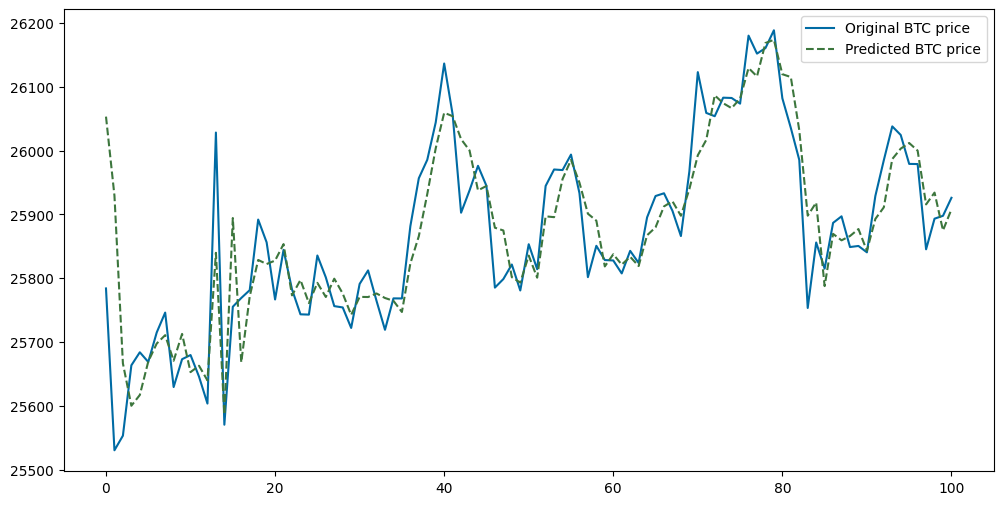

In [94]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test[0:101], label = 'Original BTC price');
ax.plot(y_pred_boosted[0:101], linestyle='--', color='#3c763d', label = 'Predicted BTC price'); 
ax.legend();
ax.set_title("");

##### Search for model combination

In [59]:
def hybrid(model1, model2):
    model1.fit(trend_X_train, y_train)
    y_fit = model1.predict(trend_X_train)
    y_pred = model1.predict(trend_X_test)

    y_resid = y_train - y_fit.reshape(-1, 1)

    model2.fit(resid_X_train, y_resid)
    y_pred_boosted = model2.predict(resid_X_test).reshape(-1, 1) + y_pred.reshape(-1, 1) + seasonal_X_test
    
    return y_pred_boosted, rmse(y_test, y_pred_boosted), MAPE(y_test, y_pred_boosted)

In [60]:
# list of all models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

regressor1 = LinearRegression()
regressor2 = Ridge()
svr = SVR()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
voting = VotingRegressor([('LR', regressor1), ('Ridge', regressor2), ('svr', svr), ('KNN', knn), ('dt', dt), ('rf', rf),
                          ('gb', gb), ('xgb', xgb)])

In [61]:
model_list = [regressor1, regressor2, svr, knn, dt, rf, gb, xgb, voting]
error_list = []
combination = []

for i in model_list:
    for j in model_list:
        print('Iteration started: ', str(len(error_list) + 1))
        #print('Training started with: ', i, ', ', j)
        point1, rmse_error, mdape_error = hybrid(i, j)
        error_list.append(rmse_error)
        combination.append([i, j])
        
ind = error_list.index(min(error_list))
best_combo = combination[ind]
print("==========Hybrid Model Combination search result==========")
print("Best error: ", str(error_list[ind]), ', with combination: ', best_combo)

Iteration started:  1
Iteration started:  2
Iteration started:  3
Iteration started:  4
Iteration started:  5
Iteration started:  6
Iteration started:  7
Iteration started:  8
Iteration started:  9
Iteration started:  10
Iteration started:  11
Iteration started:  12
Iteration started:  13
Iteration started:  14
Iteration started:  15
Iteration started:  16
Iteration started:  17
Iteration started:  18
Iteration started:  19
Iteration started:  20
Iteration started:  21
Iteration started:  22
Iteration started:  23
Iteration started:  24
Iteration started:  25
Iteration started:  26
Iteration started:  27
Iteration started:  28
Iteration started:  29
Iteration started:  30
Iteration started:  31
Iteration started:  32
Iteration started:  33
Iteration started:  34
Iteration started:  35
Iteration started:  36
Iteration started:  37
Iteration started:  38
Iteration started:  39
Iteration started:  40
Iteration started:  41
Iteration started:  42
Iteration started:  43
Iteration started:  

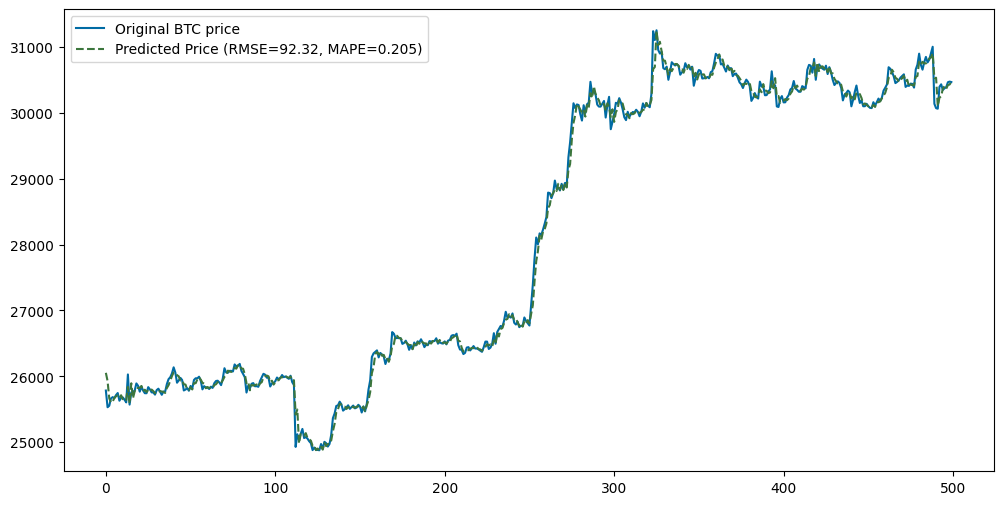

In [65]:
predicted_value, rmse_error, mdape_error = hybrid(LinearRegression(), LinearRegression())

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test, label = 'Original BTC price');
ax.plot(predicted_value, linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, float(mdape_error))); 
ax.legend();
ax.set_title("");

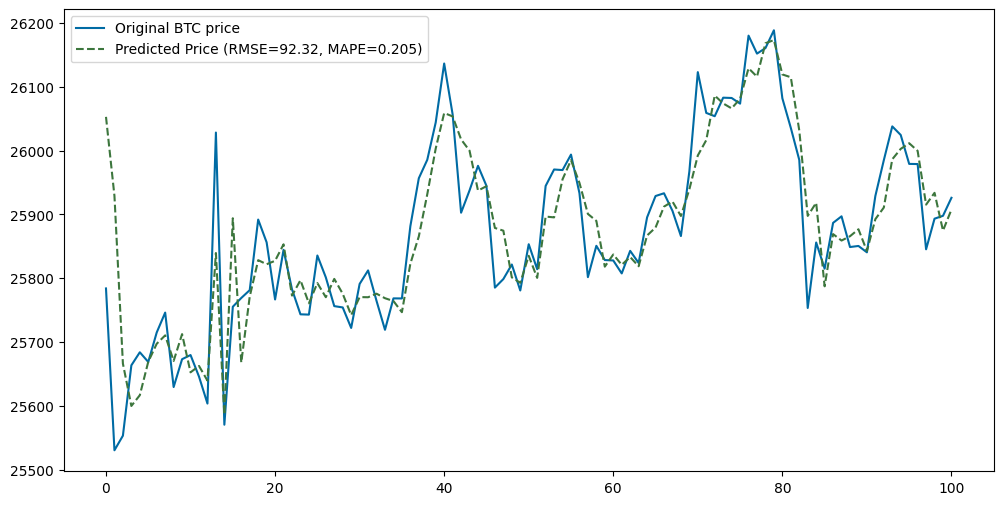

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, float(mdape_error))); 
ax.legend();
ax.set_title("");

### Deep learning

##### ANN

In [99]:
with tf.device('/cpu:0'):
    # Create sequential model from tensorflow.keras
    ANN_model1 = tf.keras.models.Sequential()
    # Add a hidden layer with input dimensions, neurons and activation function
    ANN_model1.add(Dense(units = 4, input_dim = 1, activation = 'relu',
                         activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))

    # Add output layer with one 1 ouput neuron as this is regression problem
    ANN_model1.add(Dense(1, activation = 'linear'))

    # Compile the model with optimizer and loss function
    ANN_model1.compile(optimizer = Adam(0.0005), loss = 'mse')
    
    # Create sequential model from tensorflow.keras
    ANN_model2 = tf.keras.models.Sequential()
    # Add a hidden layer with input dimensions, neurons and activation function
    ANN_model2.add(Dense(units = 4, input_dim = 1, activation = 'relu',
                         activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
    
    # Add output layer with one 1 ouput neuron as this is regression problem
    ANN_model2.add(Dense(1, activation = 'linear'))

    # Compile the model with optimizer and loss function
    ANN_model2.compile(optimizer = Adam(0.0005), loss = 'mse')

In [100]:
# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

In [101]:
def hybrid_dl(model1, model2, batch_size = 16, callbacks = [callback, REDUCE_LR]):
    history = model1.fit(trend_X_train, y_train, epochs = 1000, batch_size = batch_size, validation_split = 0.2, shuffle = False,
                        callbacks = callbacks)
    y_fit = model1.predict(trend_X_train)
    y_pred = model1.predict(trend_X_test)

    y_resid = y_train - y_fit.reshape(-1, 1)

    history = model2.fit(resid_X_train, y_resid, epochs = 1000, batch_size = batch_size, validation_split = 0.2, shuffle = False,
                        callbacks = callbacks)
    y_pred_boosted = model2.predict(resid_X_test).reshape(-1, 1) + y_pred.reshape(-1, 1) + seasonal_X_test
    
    return y_pred_boosted, rmse(y_test, y_pred_boosted), MAPE(y_test, y_pred_boosted)

In [102]:
predicted_value, rmse_error, mdape_error = hybrid_dl(ANN_model1, ANN_model2, batch_size = 32, callbacks = [callback, REDUCE_LR])

Epoch 1/1000
207/207 [==============================] - 1s 5ms/step - loss: 527878144.0000 - val_loss: 843190912.0000 - lr: 5.0000e-04
Epoch 2/1000
207/207 [==============================] - 1s 4ms/step - loss: 414596416.0000 - val_loss: 639550912.0000 - lr: 5.0000e-04
Epoch 3/1000
207/207 [==============================] - 1s 4ms/step - loss: 305101824.0000 - val_loss: 465200896.0000 - lr: 5.0000e-04
Epoch 4/1000
207/207 [==============================] - 1s 4ms/step - loss: 215309552.0000 - val_loss: 309375712.0000 - lr: 5.0000e-04
Epoch 5/1000
207/207 [==============================] - 1s 4ms/step - loss: 133520496.0000 - val_loss: 177071520.0000 - lr: 5.0000e-04
Epoch 6/1000
207/207 [==============================] - 1s 4ms/step - loss: 70466960.0000 - val_loss: 84700096.0000 - lr: 5.0000e-04
Epoch 7/1000
207/207 [==============================] - 1s 4ms/step - loss: 30699492.0000 - val_loss: 32734696.0000 - lr: 5.0000e-04
Epoch 8/1000
207/207 [==============================] - 1s 

207/207 [==============================] - 1s 4ms/step - loss: 7640.1997 - val_loss: 7264.0737 - lr: 1.2500e-04
Epoch 111/1000
207/207 [==============================] - 1s 4ms/step - loss: 7640.1948 - val_loss: 7264.0630 - lr: 1.2500e-04
Epoch 112/1000
207/207 [==============================] - 1s 4ms/step - loss: 7640.1938 - val_loss: 7264.0532 - lr: 1.2500e-04
Epoch 113/1000
207/207 [==============================] - 1s 4ms/step - loss: 7640.1924 - val_loss: 7264.0435 - lr: 1.2500e-04
Epoch 114/1000
207/207 [==============================] - 1s 4ms/step - loss: 7640.1865 - val_loss: 7264.0308 - lr: 1.2500e-04
Epoch 115/1000
207/207 [==============================] - 1s 4ms/step - loss: 7640.1851 - val_loss: 7264.0244 - lr: 1.2500e-04
Epoch 116/1000
207/207 [==============================] - 1s 4ms/step - loss: 7640.1860 - val_loss: 7264.0200 - lr: 1.2500e-04
Epoch 117/1000
207/207 [==============================] - 1s 5ms/step - loss: 7640.1802 - val_loss: 7264.0142 - lr: 1.2500e-04

207/207 [==============================] - 1s 4ms/step - loss: 7639.6436 - val_loss: 7263.0991 - lr: 6.2500e-05
Epoch 239/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.6392 - val_loss: 7263.0918 - lr: 6.2500e-05
Epoch 240/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.6421 - val_loss: 7263.0859 - lr: 6.2500e-05
Epoch 241/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.6421 - val_loss: 7263.0806 - lr: 6.2500e-05
Epoch 242/1000
207/207 [==============================] - 1s 5ms/step - loss: 7639.6411 - val_loss: 7263.0728 - lr: 6.2500e-05
Epoch 243/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.6421 - val_loss: 7263.0664 - lr: 6.2500e-05
Epoch 244/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.6372 - val_loss: 7263.0635 - lr: 6.2500e-05
Epoch 245/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.6372 - val_loss: 7263.0601 - lr: 6.2500e-05

207/207 [==============================] - 1s 4ms/step - loss: 7639.5425 - val_loss: 7262.5054 - lr: 6.2500e-05
Epoch 367/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.5415 - val_loss: 7262.5020 - lr: 6.2500e-05
Epoch 368/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.5425 - val_loss: 7262.4966 - lr: 6.2500e-05
Epoch 369/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.5415 - val_loss: 7262.4897 - lr: 6.2500e-05
Epoch 370/1000
207/207 [==============================] - 1s 5ms/step - loss: 7639.5405 - val_loss: 7262.4868 - lr: 6.2500e-05
Epoch 371/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.5391 - val_loss: 7262.4824 - lr: 6.2500e-05
Epoch 372/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.5405 - val_loss: 7262.4805 - lr: 6.2500e-05
Epoch 373/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.5400 - val_loss: 7262.4751 - lr: 6.2500e-05

207/207 [==============================] - 1s 4ms/step - loss: 7639.1416 - val_loss: 7262.2676 - lr: 7.8125e-06
Epoch 495/1000
207/207 [==============================] - 1s 5ms/step - loss: 7639.1411 - val_loss: 7262.2671 - lr: 7.8125e-06
Epoch 496/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.1411 - val_loss: 7262.2656 - lr: 7.8125e-06
Epoch 497/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.1396 - val_loss: 7262.2656 - lr: 7.8125e-06
Epoch 498/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.1411 - val_loss: 7262.2651 - lr: 7.8125e-06
Epoch 499/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.1411 - val_loss: 7262.2646 - lr: 7.8125e-06
Epoch 500/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.1416 - val_loss: 7262.2642 - lr: 7.8125e-06
Epoch 501/1000
207/207 [==============================] - 1s 4ms/step - loss: 7639.1411 - val_loss: 7262.2627 - lr: 7.8125e-06

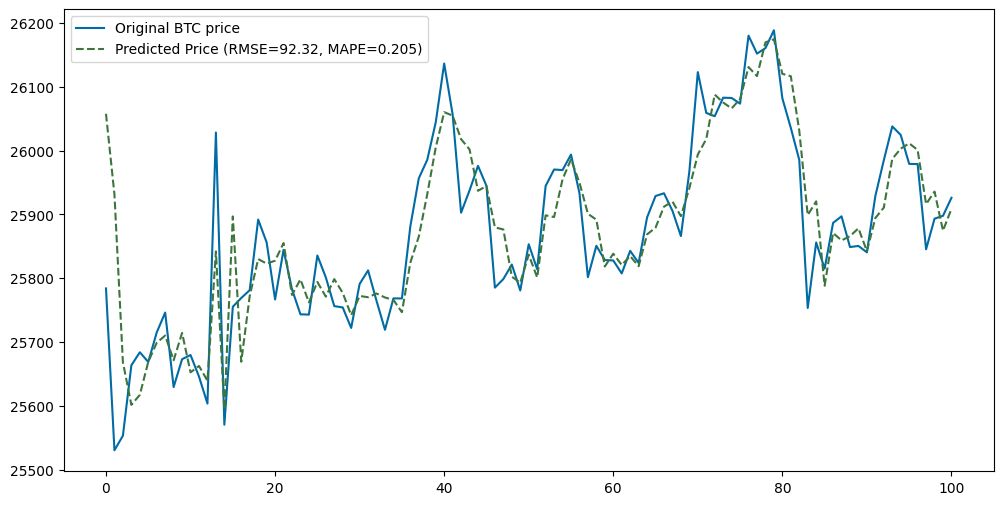

In [103]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, float(mdape_error))); 
ax.legend();
ax.set_title("");

##### LSTM

In [104]:
with tf.device('/cpu:0'):
    # Create sequential model from tensorflow.keras
    LSTM_model1 = tf.keras.models.Sequential()
    # Add a hidden layer with input dimensions, neurons and activation function
    LSTM_model1.add(LSTM(units = 10, input_shape =(1, 1), return_sequences = False, 
                        kernel_initializer = 'he_uniform', bias_initializer = 'zeros'))
    LSTM_model1.add(Dense(1, activation = 'linear'))

    # Compile the model with optimizer and loss function
    LSTM_model1.compile(optimizer = Adam(), loss = 'mse')
    
    # Create sequential model from tensorflow.keras
    LSTM_model2 = tf.keras.models.Sequential()
    # Add a hidden layer with input dimensions, neurons and activation function
    LSTM_model2.add(LSTM(units = 10, input_shape =(1, 1), return_sequences = False, 
                        kernel_initializer = 'he_uniform', bias_initializer = 'zeros'))
    # Add output layer with one 1 ouput neuron as this is regression problem
    LSTM_model2.add(Dense(1, activation = 'linear'))

    # Compile the model with optimizer and loss function
    LSTM_model2.compile(optimizer = Adam(), loss = 'mse')
    
    
# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

In [105]:
predicted_value, rmse_error, mdape_error = hybrid_dl(LSTM_model1, LSTM_model2, batch_size = 32,
                                                     callbacks = [callback, REDUCE_LR])

Epoch 1/1000
207/207 [==============================] - 3s 9ms/step - loss: 439330048.0000 - val_loss: 783505920.0000 - lr: 0.0010
Epoch 2/1000
207/207 [==============================] - 1s 7ms/step - loss: 439295104.0000 - val_loss: 783459328.0000 - lr: 0.0010
Epoch 3/1000
207/207 [==============================] - 1s 7ms/step - loss: 439260544.0000 - val_loss: 783412928.0000 - lr: 0.0010
Epoch 4/1000
207/207 [==============================] - 1s 7ms/step - loss: 439226016.0000 - val_loss: 783366592.0000 - lr: 0.0010
Epoch 5/1000
207/207 [==============================] - 1s 7ms/step - loss: 439191552.0000 - val_loss: 783320000.0000 - lr: 0.0010
Epoch 6/1000
207/207 [==============================] - 1s 7ms/step - loss: 439157088.0000 - val_loss: 783273792.0000 - lr: 0.0010
Epoch 7/1000
207/207 [==============================] - 1s 7ms/step - loss: 439122816.0000 - val_loss: 783227136.0000 - lr: 0.0010
Epoch 8/1000
207/207 [==============================] - 1s 7ms/step - loss: 4390882

Epoch 125/1000
207/207 [==============================] - 1s 7ms/step - loss: 435077632.0000 - val_loss: 777769728.0000 - lr: 0.0010
Epoch 126/1000
207/207 [==============================] - 1s 7ms/step - loss: 435043424.0000 - val_loss: 777723328.0000 - lr: 0.0010
Epoch 127/1000
207/207 [==============================] - 1s 7ms/step - loss: 435009216.0000 - val_loss: 777677312.0000 - lr: 0.0010
Epoch 128/1000
207/207 [==============================] - 1s 7ms/step - loss: 434974848.0000 - val_loss: 777631104.0000 - lr: 0.0010
Epoch 129/1000
207/207 [==============================] - 1s 7ms/step - loss: 434940992.0000 - val_loss: 777584960.0000 - lr: 0.0010
Epoch 130/1000
207/207 [==============================] - 1s 7ms/step - loss: 434906720.0000 - val_loss: 777538688.0000 - lr: 0.0010
Epoch 131/1000
207/207 [==============================] - 1s 7ms/step - loss: 434872384.0000 - val_loss: 777492608.0000 - lr: 0.0010
Epoch 132/1000
207/207 [==============================] - 1s 7ms/step

Epoch 248/1000
207/207 [==============================] - 1s 7ms/step - loss: 430881856.0000 - val_loss: 772101504.0000 - lr: 0.0010
Epoch 249/1000
207/207 [==============================] - 1s 7ms/step - loss: 430847648.0000 - val_loss: 772055680.0000 - lr: 0.0010
Epoch 250/1000
207/207 [==============================] - 1s 7ms/step - loss: 430813632.0000 - val_loss: 772009664.0000 - lr: 0.0010
Epoch 251/1000
207/207 [==============================] - 1s 7ms/step - loss: 430779776.0000 - val_loss: 771963456.0000 - lr: 0.0010
Epoch 252/1000
207/207 [==============================] - 1s 7ms/step - loss: 430745952.0000 - val_loss: 771917632.0000 - lr: 0.0010
Epoch 253/1000
207/207 [==============================] - 1s 7ms/step - loss: 430711520.0000 - val_loss: 771871488.0000 - lr: 0.0010
Epoch 254/1000
207/207 [==============================] - 1s 7ms/step - loss: 430677760.0000 - val_loss: 771825664.0000 - lr: 0.0010
Epoch 255/1000
207/207 [==============================] - 1s 7ms/step

Epoch 371/1000
207/207 [==============================] - 1s 7ms/step - loss: 426706784.0000 - val_loss: 766454080.0000 - lr: 0.0010
Epoch 372/1000
207/207 [==============================] - 1s 7ms/step - loss: 426672960.0000 - val_loss: 766408384.0000 - lr: 0.0010
Epoch 373/1000
207/207 [==============================] - 1s 7ms/step - loss: 426639008.0000 - val_loss: 766362496.0000 - lr: 0.0010
Epoch 374/1000
207/207 [==============================] - 1s 7ms/step - loss: 426605088.0000 - val_loss: 766316800.0000 - lr: 0.0010
Epoch 375/1000
207/207 [==============================] - 1s 7ms/step - loss: 426571328.0000 - val_loss: 766270848.0000 - lr: 0.0010
Epoch 376/1000
207/207 [==============================] - 1s 7ms/step - loss: 426537536.0000 - val_loss: 766225024.0000 - lr: 0.0010
Epoch 377/1000
207/207 [==============================] - 1s 7ms/step - loss: 426503712.0000 - val_loss: 766179136.0000 - lr: 0.0010
Epoch 378/1000
207/207 [==============================] - 1s 7ms/step

Epoch 494/1000
207/207 [==============================] - 1s 7ms/step - loss: 422553472.0000 - val_loss: 760828864.0000 - lr: 0.0010
Epoch 495/1000
207/207 [==============================] - 1s 7ms/step - loss: 422519744.0000 - val_loss: 760783168.0000 - lr: 0.0010
Epoch 496/1000
207/207 [==============================] - 1s 7ms/step - loss: 422486144.0000 - val_loss: 760737472.0000 - lr: 0.0010
Epoch 497/1000
207/207 [==============================] - 1s 7ms/step - loss: 422452448.0000 - val_loss: 760692032.0000 - lr: 0.0010
Epoch 498/1000
207/207 [==============================] - 1s 7ms/step - loss: 422418848.0000 - val_loss: 760646272.0000 - lr: 0.0010
Epoch 499/1000
207/207 [==============================] - 1s 7ms/step - loss: 422384992.0000 - val_loss: 760600576.0000 - lr: 0.0010
Epoch 500/1000
207/207 [==============================] - 1s 7ms/step - loss: 422351424.0000 - val_loss: 760554944.0000 - lr: 0.0010
Epoch 501/1000
207/207 [==============================] - 1s 7ms/step

Epoch 617/1000
207/207 [==============================] - 1s 7ms/step - loss: 418422016.0000 - val_loss: 755225600.0000 - lr: 0.0010
Epoch 618/1000
207/207 [==============================] - 1s 7ms/step - loss: 418388416.0000 - val_loss: 755180288.0000 - lr: 0.0010
Epoch 619/1000
207/207 [==============================] - 1s 7ms/step - loss: 418354912.0000 - val_loss: 755134720.0000 - lr: 0.0010
Epoch 620/1000
207/207 [==============================] - 1s 7ms/step - loss: 418321312.0000 - val_loss: 755089216.0000 - lr: 0.0010
Epoch 621/1000
207/207 [==============================] - 1s 7ms/step - loss: 418287904.0000 - val_loss: 755043840.0000 - lr: 0.0010
Epoch 622/1000
207/207 [==============================] - 1s 7ms/step - loss: 418254464.0000 - val_loss: 754998272.0000 - lr: 0.0010
Epoch 623/1000
207/207 [==============================] - 1s 7ms/step - loss: 418220768.0000 - val_loss: 754952896.0000 - lr: 0.0010
Epoch 624/1000
207/207 [==============================] - 1s 7ms/step

Epoch 740/1000
207/207 [==============================] - 1s 7ms/step - loss: 414312864.0000 - val_loss: 749645760.0000 - lr: 0.0010
Epoch 741/1000
207/207 [==============================] - 1s 7ms/step - loss: 414279808.0000 - val_loss: 749600448.0000 - lr: 0.0010
Epoch 742/1000
207/207 [==============================] - 1s 7ms/step - loss: 414246368.0000 - val_loss: 749555200.0000 - lr: 0.0010
Epoch 743/1000
207/207 [==============================] - 1s 7ms/step - loss: 414212928.0000 - val_loss: 749510016.0000 - lr: 0.0010
Epoch 744/1000
207/207 [==============================] - 1s 7ms/step - loss: 414179808.0000 - val_loss: 749464704.0000 - lr: 0.0010
Epoch 745/1000
207/207 [==============================] - 1s 7ms/step - loss: 414146496.0000 - val_loss: 749419648.0000 - lr: 0.0010
Epoch 746/1000
207/207 [==============================] - 1s 7ms/step - loss: 414113056.0000 - val_loss: 749374080.0000 - lr: 0.0010
Epoch 747/1000
207/207 [==============================] - 1s 7ms/step

Epoch 863/1000
207/207 [==============================] - 1s 7ms/step - loss: 410225120.0000 - val_loss: 744087104.0000 - lr: 0.0010
Epoch 864/1000
207/207 [==============================] - 1s 7ms/step - loss: 410192000.0000 - val_loss: 744042048.0000 - lr: 0.0010
Epoch 865/1000
207/207 [==============================] - 1s 7ms/step - loss: 410158752.0000 - val_loss: 743997056.0000 - lr: 0.0010
Epoch 866/1000
207/207 [==============================] - 1s 7ms/step - loss: 410125632.0000 - val_loss: 743951808.0000 - lr: 0.0010
Epoch 867/1000
207/207 [==============================] - 1s 7ms/step - loss: 410092480.0000 - val_loss: 743906496.0000 - lr: 0.0010
Epoch 868/1000
207/207 [==============================] - 1s 7ms/step - loss: 410059360.0000 - val_loss: 743861696.0000 - lr: 0.0010
Epoch 869/1000
207/207 [==============================] - 1s 7ms/step - loss: 410026176.0000 - val_loss: 743816448.0000 - lr: 0.0010
Epoch 870/1000
207/207 [==============================] - 1s 7ms/step

Epoch 986/1000
207/207 [==============================] - 1s 7ms/step - loss: 406157696.0000 - val_loss: 738548928.0000 - lr: 0.0010
Epoch 987/1000
207/207 [==============================] - 1s 7ms/step - loss: 406124896.0000 - val_loss: 738504000.0000 - lr: 0.0010
Epoch 988/1000
207/207 [==============================] - 1s 7ms/step - loss: 406091712.0000 - val_loss: 738459072.0000 - lr: 0.0010
Epoch 989/1000
207/207 [==============================] - 1s 7ms/step - loss: 406058688.0000 - val_loss: 738414208.0000 - lr: 0.0010
Epoch 990/1000
207/207 [==============================] - 1s 7ms/step - loss: 406025984.0000 - val_loss: 738369216.0000 - lr: 0.0010
Epoch 991/1000
207/207 [==============================] - 1s 7ms/step - loss: 405992800.0000 - val_loss: 738324224.0000 - lr: 0.0010
Epoch 992/1000
207/207 [==============================] - 1s 7ms/step - loss: 405960032.0000 - val_loss: 738279296.0000 - lr: 0.0010
Epoch 993/1000
207/207 [==============================] - 1s 7ms/step

207/207 [==============================] - 1s 6ms/step - loss: 397757472.0000 - val_loss: 727061952.0000 - lr: 0.0010
Epoch 110/1000
207/207 [==============================] - 1s 6ms/step - loss: 397688032.0000 - val_loss: 726967104.0000 - lr: 0.0010
Epoch 111/1000
207/207 [==============================] - 1s 6ms/step - loss: 397618560.0000 - val_loss: 726872256.0000 - lr: 0.0010
Epoch 112/1000
207/207 [==============================] - 1s 6ms/step - loss: 397549184.0000 - val_loss: 726777344.0000 - lr: 0.0010
Epoch 113/1000
207/207 [==============================] - 1s 6ms/step - loss: 397479776.0000 - val_loss: 726682496.0000 - lr: 0.0010
Epoch 114/1000
207/207 [==============================] - 1s 6ms/step - loss: 397410336.0000 - val_loss: 726587648.0000 - lr: 0.0010
Epoch 115/1000
207/207 [==============================] - 1s 6ms/step - loss: 397340864.0000 - val_loss: 726492608.0000 - lr: 0.0010
Epoch 116/1000
207/207 [==============================] - 1s 6ms/step - loss: 397271

Epoch 171/1000
207/207 [==============================] - 1s 6ms/step - loss: 393463072.0000 - val_loss: 721189312.0000 - lr: 0.0010
Epoch 172/1000
207/207 [==============================] - 1s 6ms/step - loss: 393394112.0000 - val_loss: 721095040.0000 - lr: 0.0010
Epoch 173/1000
207/207 [==============================] - 1s 6ms/step - loss: 393324960.0000 - val_loss: 721000640.0000 - lr: 0.0010
Epoch 174/1000
207/207 [==============================] - 1s 6ms/step - loss: 393255904.0000 - val_loss: 720905984.0000 - lr: 0.0010
Epoch 175/1000
207/207 [==============================] - 1s 6ms/step - loss: 393186912.0000 - val_loss: 720811392.0000 - lr: 0.0010
Epoch 176/1000
207/207 [==============================] - 1s 6ms/step - loss: 393117920.0000 - val_loss: 720717056.0000 - lr: 0.0010
Epoch 177/1000
207/207 [==============================] - 1s 6ms/step - loss: 393048800.0000 - val_loss: 720622528.0000 - lr: 0.0010
Epoch 178/1000
207/207 [==============================] - 1s 6ms/step

Epoch 294/1000
207/207 [==============================] - 1s 6ms/step - loss: 385015392.0000 - val_loss: 709611776.0000 - lr: 0.0010
Epoch 295/1000
207/207 [==============================] - 1s 6ms/step - loss: 384947072.0000 - val_loss: 709517888.0000 - lr: 0.0010
Epoch 296/1000
207/207 [==============================] - 1s 6ms/step - loss: 384878784.0000 - val_loss: 709424256.0000 - lr: 0.0010
Epoch 297/1000
207/207 [==============================] - 1s 6ms/step - loss: 384810400.0000 - val_loss: 709330496.0000 - lr: 0.0010
Epoch 298/1000
207/207 [==============================] - 1s 6ms/step - loss: 384742240.0000 - val_loss: 709236864.0000 - lr: 0.0010
Epoch 299/1000
207/207 [==============================] - 1s 6ms/step - loss: 384673888.0000 - val_loss: 709143168.0000 - lr: 0.0010
Epoch 300/1000
207/207 [==============================] - 1s 6ms/step - loss: 384605632.0000 - val_loss: 709049536.0000 - lr: 0.0010
Epoch 301/1000
207/207 [==============================] - 1s 7ms/step

Epoch 417/1000
207/207 [==============================] - 1s 6ms/step - loss: 376663616.0000 - val_loss: 698130752.0000 - lr: 0.0010
Epoch 418/1000
207/207 [==============================] - 1s 6ms/step - loss: 376596064.0000 - val_loss: 698037760.0000 - lr: 0.0010
Epoch 419/1000
207/207 [==============================] - 1s 6ms/step - loss: 376528768.0000 - val_loss: 697944768.0000 - lr: 0.0010
Epoch 420/1000
207/207 [==============================] - 1s 6ms/step - loss: 376461056.0000 - val_loss: 697851840.0000 - lr: 0.0010
Epoch 421/1000
207/207 [==============================] - 1s 6ms/step - loss: 376393632.0000 - val_loss: 697759040.0000 - lr: 0.0010
Epoch 422/1000
207/207 [==============================] - 1s 6ms/step - loss: 376326176.0000 - val_loss: 697666112.0000 - lr: 0.0010
Epoch 423/1000
207/207 [==============================] - 1s 6ms/step - loss: 376258656.0000 - val_loss: 697573184.0000 - lr: 0.0010
Epoch 424/1000
207/207 [==============================] - 1s 6ms/step

Epoch 540/1000
207/207 [==============================] - 1s 6ms/step - loss: 368409696.0000 - val_loss: 686749120.0000 - lr: 0.0010
Epoch 541/1000
207/207 [==============================] - 1s 6ms/step - loss: 368342976.0000 - val_loss: 686657024.0000 - lr: 0.0010
Epoch 542/1000
207/207 [==============================] - 1s 6ms/step - loss: 368276160.0000 - val_loss: 686564800.0000 - lr: 0.0010
Epoch 543/1000
207/207 [==============================] - 1s 6ms/step - loss: 368209472.0000 - val_loss: 686472640.0000 - lr: 0.0010
Epoch 544/1000
207/207 [==============================] - 1s 6ms/step - loss: 368142944.0000 - val_loss: 686380416.0000 - lr: 0.0010
Epoch 545/1000
207/207 [==============================] - 1s 6ms/step - loss: 368076096.0000 - val_loss: 686288384.0000 - lr: 0.0010
Epoch 546/1000
207/207 [==============================] - 1s 6ms/step - loss: 368009472.0000 - val_loss: 686196224.0000 - lr: 0.0010
Epoch 547/1000
207/207 [==============================] - 1s 6ms/step

Epoch 663/1000
207/207 [==============================] - 1s 6ms/step - loss: 360252128.0000 - val_loss: 675464896.0000 - lr: 0.0010
Epoch 664/1000
207/207 [==============================] - 1s 6ms/step - loss: 360186368.0000 - val_loss: 675373376.0000 - lr: 0.0010
Epoch 665/1000
207/207 [==============================] - 1s 6ms/step - loss: 360120416.0000 - val_loss: 675282240.0000 - lr: 0.0010
Epoch 666/1000
207/207 [==============================] - 1s 6ms/step - loss: 360054336.0000 - val_loss: 675190912.0000 - lr: 0.0010
Epoch 667/1000
207/207 [==============================] - 1s 6ms/step - loss: 359988576.0000 - val_loss: 675099584.0000 - lr: 0.0010
Epoch 668/1000
207/207 [==============================] - 1s 6ms/step - loss: 359922720.0000 - val_loss: 675008192.0000 - lr: 0.0010
Epoch 669/1000
207/207 [==============================] - 1s 6ms/step - loss: 359856768.0000 - val_loss: 674916864.0000 - lr: 0.0010
Epoch 670/1000
207/207 [==============================] - 1s 6ms/step

Epoch 786/1000
207/207 [==============================] - 1s 6ms/step - loss: 352190688.0000 - val_loss: 664277568.0000 - lr: 0.0010
Epoch 787/1000
207/207 [==============================] - 1s 6ms/step - loss: 352125568.0000 - val_loss: 664187008.0000 - lr: 0.0010
Epoch 788/1000
207/207 [==============================] - 1s 6ms/step - loss: 352060384.0000 - val_loss: 664096576.0000 - lr: 0.0010
Epoch 789/1000
207/207 [==============================] - 1s 6ms/step - loss: 351995200.0000 - val_loss: 664006016.0000 - lr: 0.0010
Epoch 790/1000
207/207 [==============================] - 1s 7ms/step - loss: 351929920.0000 - val_loss: 663915200.0000 - lr: 0.0010
Epoch 791/1000
207/207 [==============================] - 1s 6ms/step - loss: 351864992.0000 - val_loss: 663824832.0000 - lr: 0.0010
Epoch 792/1000
207/207 [==============================] - 1s 6ms/step - loss: 351799872.0000 - val_loss: 663734272.0000 - lr: 0.0010
Epoch 793/1000
207/207 [==============================] - 1s 6ms/step

Epoch 909/1000
207/207 [==============================] - 1s 6ms/step - loss: 344222016.0000 - val_loss: 653182656.0000 - lr: 0.0010
Epoch 910/1000
207/207 [==============================] - 1s 6ms/step - loss: 344157568.0000 - val_loss: 653092800.0000 - lr: 0.0010
Epoch 911/1000
207/207 [==============================] - 1s 6ms/step - loss: 344093152.0000 - val_loss: 653002944.0000 - lr: 0.0010
Epoch 912/1000
207/207 [==============================] - 1s 6ms/step - loss: 344028736.0000 - val_loss: 652913088.0000 - lr: 0.0010
Epoch 913/1000
207/207 [==============================] - 1s 6ms/step - loss: 343964352.0000 - val_loss: 652823424.0000 - lr: 0.0010
Epoch 914/1000
207/207 [==============================] - 1s 6ms/step - loss: 343900032.0000 - val_loss: 652733632.0000 - lr: 0.0010
Epoch 915/1000
207/207 [==============================] - 1s 6ms/step - loss: 343835520.0000 - val_loss: 652643840.0000 - lr: 0.0010
Epoch 916/1000
207/207 [==============================] - 1s 6ms/step

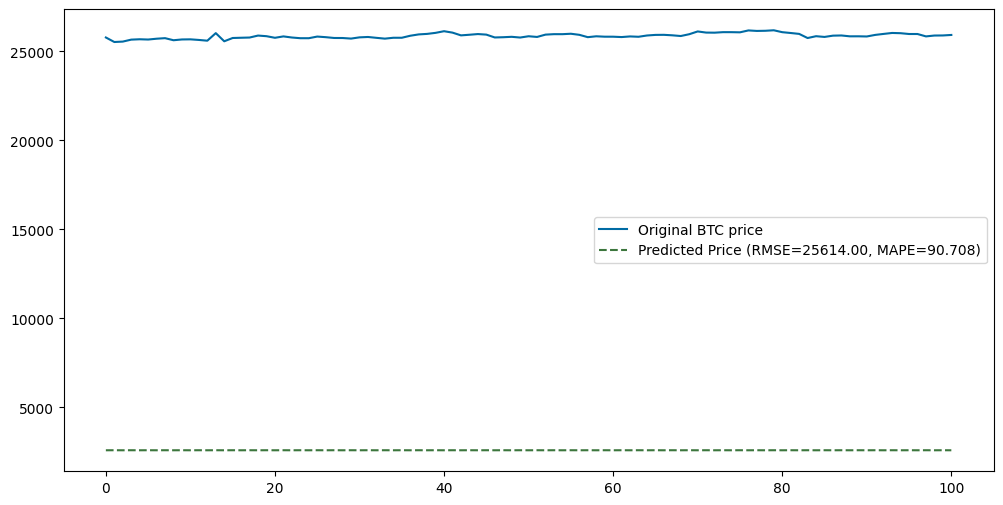

In [108]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, float(mdape_error))); 
ax.legend();
ax.set_title("");

## Multivariate methods

In [109]:
df['day_of_week'] = 1
for i in range(len(df.index)):
    if df['day'][i] == 'Sunday':
        df['day_of_week'][i] = 1
    elif df['day'][i] == 'Monday':
        df['day_of_week'][i] = 2
    elif df['day'][i] == 'Tuesday':
        df['day_of_week'][i] = 3
    elif df['day'][i] == 'Wednesday':
        df['day_of_week'][i] = 4
    elif df['day'][i] == 'Thursday':
        df['day_of_week'][i] = 5
    elif df['day'][i] == 'Friday':
        df['day_of_week'][i] = 6
    elif df['day'][i] == 'Saturday':
        df['day_of_week'][i] = 7

In [110]:
df.drop('day', axis = 1, inplace = True)
new_df = df.copy()
new_df['trend'] = trend_estimate
new_df['seasonal'] = seasonal_estimate
new_df['resid'] = residual_estimate

In [111]:
new_df['close'] = new_df['close'].shift(-1)
new_df = new_df.dropna()

In [112]:
new_df.columns

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close',
       'hourly_volume', 'top_tier_volume_quote', 'top_tier_volume_base',
       'top_tier_volume_total', 'cccagg_volume_quote', 'cccagg_volume_base',
       'cccagg_volume_total', 'total_volume_quote', 'total_volume_base',
       'total_volume_total', 'eth_open', 'eth_close', 'bnb_open', 'bnb_close',
       'usdt_open', 'usdt_close', 'sol_open', 'sol_close', 'hourly_return',
       '3_hourly_return', '5_hourly_return', '12_hourly_return',
       '3_hourly_volatility', '5_hourly_volatility', '12_hourly_volatility',
       'daily_volatility', 'trend_score', 'Compound_score', 'Polarity',
       'time_of_the_day', 'day_of_month', 'weekend', 'day_of_week', 'trend',
       'seasonal', 'resid'],
      dtype='object')

##### With base features

In [250]:
#trend = new_df.drop(['seasonal', 'resid', 'close'], axis = 1)
trend = new_df[['high', 'low', 'open', 'volumefrom', 'volumeto', 'hourly_volume', 'hourly_return', 'trend']]
seasonal = new_df[['seasonal']]
resid = new_df[['resid']]
y = new_df[['close']]

trend_X_train, trend_X_test, y_train, y_test = train_test_split(trend, y, test_size = 500, shuffle = False)
resid_X_train, resid_X_test = train_test_split(resid, test_size = 500, shuffle = False)
seasonal_X_train, seasonal_X_test = train_test_split(seasonal, test_size = 500, shuffle = False)

In [251]:
trend_X_train.shape, trend_X_test.shape, y_train.shape, y_test.shape, resid_X_train.shape, resid_X_test.shape, seasonal_X_train.shape, seasonal_X_test.shape

((8259, 8),
 (500, 8),
 (8259, 1),
 (500, 1),
 (8259, 1),
 (500, 1),
 (8259, 1),
 (500, 1))

In [252]:
# trend_X_train = trend_X_train.reshape(-1, 1)
# trend_X_test = trend_X_test.reshape(-1, 1)
# resid_X_train = resid_X_train.reshape(-1, 1)
# resid_X_test = resid_X_test.reshape(-1, 1)
# seasonal_X_train = seasonal_X_train.reshape(-1, 1)
# seasonal_X_test = seasonal_X_test.reshape(-1, 1)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

In [253]:
# trend_X_train.shape, trend_X_test.shape, y_train.shape, y_test.shape, resid_X_train.shape, resid_X_test.shape, seasonal_X_train.shape, seasonal_X_test.shape

In [254]:
# Functions for transformation
y_train_original = y_train.copy()
y_test_original = y_test.copy()

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

cols1 = trend_X_train.columns
trend_enc = RobustScaler()
trend_X_train[cols1] = trend_enc.fit_transform(trend_X_train[cols1])
trend_X_test[cols1] = trend_enc.transform(trend_X_test[cols1])

cols2 = y_train.columns
y_enc = RobustScaler()
y_train[cols2] = y_enc.fit_transform(y_train[cols2])
y_test[cols2] = y_enc.transform(y_test[cols2])

In [118]:
# Fit trend model
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(trend_X_train, y_train)

LinearRegression(fit_intercept=False)

In [119]:
y_fit = model.predict(trend_X_train)
y_pred = model.predict(trend_X_test)

In [120]:
y_pred.shape

(500, 1)

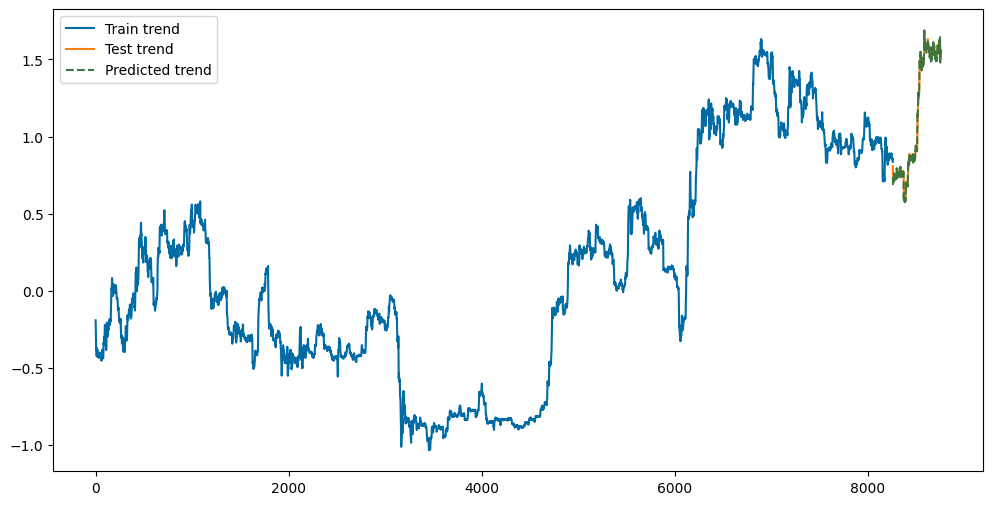

In [121]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, len(new_df.index) - 500), trend_X_train['trend'][:len(new_df.index) - 500], label = 'Train trend');
ax.plot(np.arange(len(new_df.index) - 500, len(new_df.index)), trend_X_test['trend'], label = 'Test trend');
#ax.plot(np.arange(0, len(df.index) - 500), y_fit, linestyle='--', color='#ff7823');
ax.plot(np.arange(len(new_df.index) - 500, len(new_df.index)), y_pred, linestyle='--', color='#3c763d', label = 'Predicted trend'); 
ax.legend();
ax.set_title("");

In [122]:
rmse(trend_X_test['trend'], y_pred)

0.018131868938531477

In [123]:
y_pred = y_enc.inverse_transform(y_pred)
y_fit = y_enc.inverse_transform(y_fit)

In [124]:
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train_original - y_fit

In [125]:
# Train XGBoost on the residuals
xgb = LinearRegression()
xgb.fit(resid_X_train, y_resid)

LinearRegression()

In [126]:
# Add the predicted residuals onto the predicted trends
y_pred_boosted = xgb.predict(resid_X_test).reshape(-1, 1) + y_pred + seasonal_X_test

In [127]:
rmse(y_test_original, y_pred_boosted)

4.719469945784053

In [128]:
MAPE(y_test_original.values, y_pred_boosted.values)

array([0.01136092])

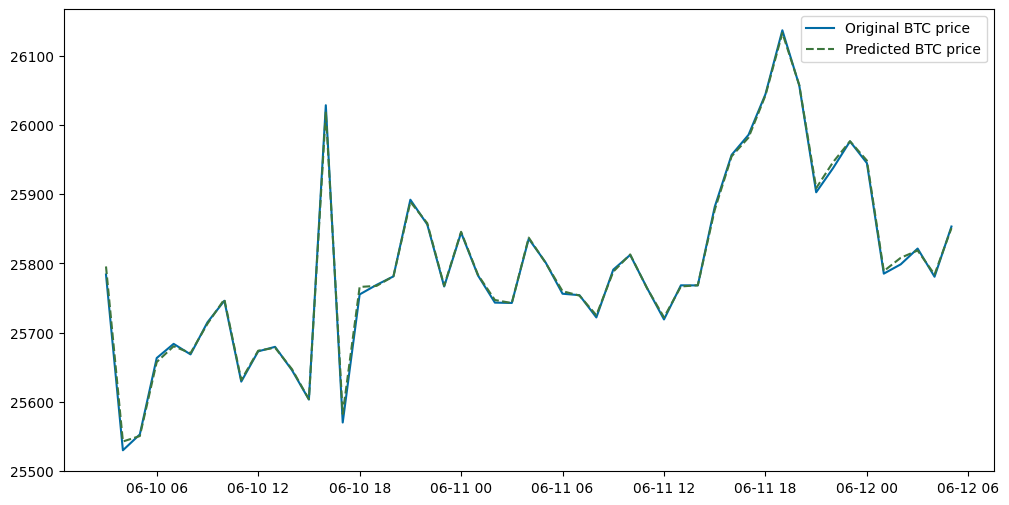

In [129]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:51], label = 'Original BTC price');
ax.plot(y_pred_boosted[0:51], linestyle='--', color='#3c763d', label = 'Predicted BTC price'); 
ax.legend();
ax.set_title("");

##### Search for model combination

In [130]:
def hybrid(model1, model2):
    model1.fit(trend_X_train, y_train)
    y_fit = model1.predict(trend_X_train)
    y_pred = model1.predict(trend_X_test)
    
    y_pred = y_enc.inverse_transform(y_pred.reshape(-1,1))
    y_fit = y_enc.inverse_transform(y_fit.reshape(-1,1))

    y_resid = y_train_original - y_fit

    model2.fit(resid_X_train, y_resid)
    y_pred_boosted = model2.predict(resid_X_test).reshape(-1, 1) + y_pred.reshape(-1, 1) + seasonal_X_test
    
    return y_pred_boosted, rmse(y_test_original, y_pred_boosted), float(MAPE(y_test_original.values, y_pred_boosted.values))

In [131]:
# list of all models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

regressor1 = LinearRegression()
regressor2 = Ridge()
svr = SVR()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
voting = VotingRegressor([('LR', regressor1), ('Ridge', regressor2), ('svr', svr), ('KNN', knn), ('dt', dt), ('rf', rf),
                          ('gb', gb), ('xgb', xgb)])

In [132]:
model_list = [regressor1, regressor2, svr, knn, dt, rf, gb, xgb, voting]
error_list = []
combination = []

for i in model_list:
    for j in model_list:
        print('Iteration started: ', str(len(error_list) + 1))
        #print('Training started with: ', i, ', ', j)
        point1, rmse_error, mdape_error = hybrid(i, j)
        error_list.append(rmse_error)
        combination.append([i, j])
        
ind = error_list.index(min(error_list))
best_combo = combination[ind]
print("==========Hybrid Model Combination search result==========")
print("Best error: ", str(error_list[ind]), ', with combination: ', best_combo)

Iteration started:  1
Iteration started:  2
Iteration started:  3
Iteration started:  4
Iteration started:  5
Iteration started:  6
Iteration started:  7
Iteration started:  8
Iteration started:  9
Iteration started:  10
Iteration started:  11
Iteration started:  12
Iteration started:  13
Iteration started:  14
Iteration started:  15
Iteration started:  16
Iteration started:  17
Iteration started:  18
Iteration started:  19
Iteration started:  20
Iteration started:  21
Iteration started:  22
Iteration started:  23
Iteration started:  24
Iteration started:  25
Iteration started:  26
Iteration started:  27
Iteration started:  28
Iteration started:  29
Iteration started:  30
Iteration started:  31
Iteration started:  32
Iteration started:  33
Iteration started:  34
Iteration started:  35
Iteration started:  36
Iteration started:  37
Iteration started:  38
Iteration started:  39
Iteration started:  40
Iteration started:  41
Iteration started:  42
Iteration started:  43
Iteration started:  

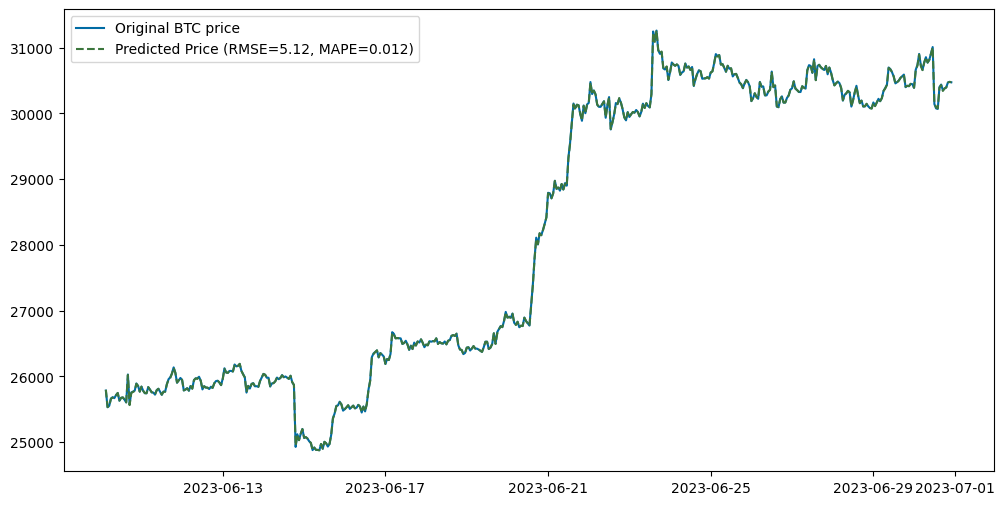

In [138]:
predicted_value, rmse_error, mdape_error = hybrid(LinearRegression(), LinearRegression())

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original, label = 'Original BTC price');
ax.plot(predicted_value, linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

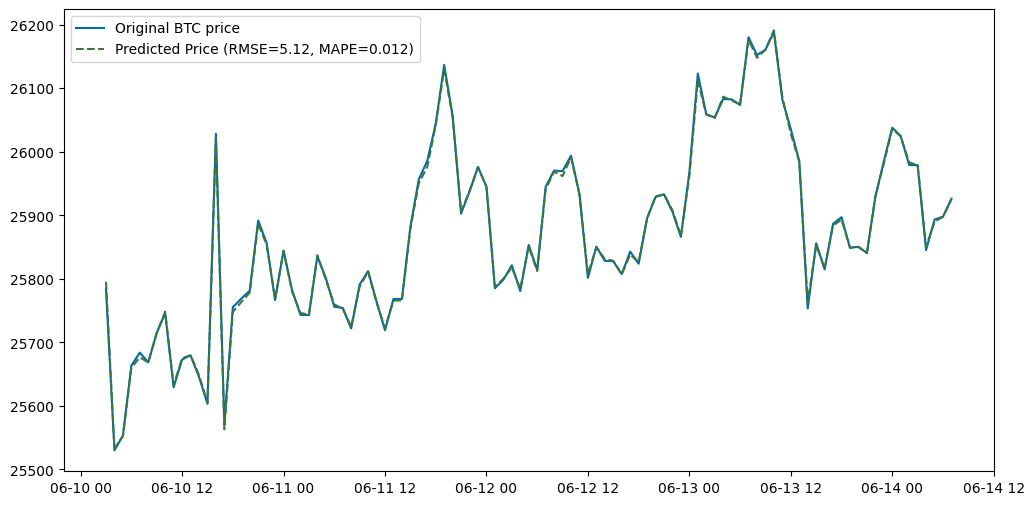

In [141]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

### Deep learning

##### ANN

In [309]:
def hybrid_dl(model1, model2, batch_size = 16, callbacks = [callback, REDUCE_LR]):
    history = model1.fit(trend_X_train, y_train, epochs = 500, batch_size = batch_size, validation_split = 0.2, shuffle = False,
                        callbacks = callbacks)
    y_fit = model1.predict(trend_X_train)
    y_pred = model1.predict(trend_X_test)
    
    y_pred = y_enc.inverse_transform(y_pred)
    y_fit = y_enc.inverse_transform(y_fit)

    y_resid = y_train_original - y_fit

    history = model2.fit(resid_X_train, y_resid, epochs = 500, batch_size = batch_size, validation_split = 0.2, shuffle = False,
                        callbacks = callbacks)
    y_pred_boosted = model2.predict(resid_X_test).reshape(-1, 1) + y_pred.reshape(-1, 1) + seasonal_X_test
    
    return y_pred_boosted, rmse(y_test_original, y_pred_boosted), float(MAPE(y_test_original.values, y_pred_boosted.values))

In [227]:
def create_ann(units = 24, input_dim = 8, optimizer = RMSprop(learning_rate = 0.0001)):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        ANN_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        ANN_model.add(Dense(units = units, input_dim = input_dim, activation = 'relu',
                             activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))

        # Add output layer with one 1 ouput neuron as this is regression problem
        ANN_model.add(Dense(1, activation = 'linear'))

        # Compile the model with optimizer and loss function
        ANN_model.compile(optimizer = optimizer, loss = 'mse')
        
    return ANN_model

In [228]:
ANN_model1 = create_ann(units = 24, input_dim = 8, optimizer = RMSprop(learning_rate = 0.0001))
ANN_model2 = create_ann(units = 10, input_dim = 1, optimizer = RMSprop(learning_rate = 0.0001))

# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

In [175]:
predicted_value, rmse_error, mdape_error = hybrid_dl(ANN_model1, ANN_model2, batch_size = 32, callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 3s 12ms/step - loss: 0.4848 - val_loss: 2.3642 - lr: 1.0000e-04
Epoch 2/500
207/207 [==============================] - 2s 10ms/step - loss: 0.3359 - val_loss: 1.8083 - lr: 1.0000e-04
Epoch 3/500
207/207 [==============================] - 2s 10ms/step - loss: 0.2238 - val_loss: 1.3224 - lr: 1.0000e-04
Epoch 4/500
207/207 [==============================] - 2s 10ms/step - loss: 0.1425 - val_loss: 0.9080 - lr: 1.0000e-04
Epoch 5/500
207/207 [==============================] - 2s 10ms/step - loss: 0.0869 - val_loss: 0.5671 - lr: 1.0000e-04
Epoch 6/500
207/207 [==============================] - 2s 10ms/step - loss: 0.0516 - val_loss: 0.3286 - lr: 1.0000e-04
Epoch 7/500
207/207 [==============================] - 2s 10ms/step - loss: 0.0307 - val_loss: 0.1778 - lr: 1.0000e-04
Epoch 8/500
207/207 [==============================] - 2s 10ms/step - loss: 0.0195 - val_loss: 0.0926 - lr: 1.0000e-04
Epoch 9/500
207/207 [===========================

Epoch 32/700
207/207 [==============================] - 2s 10ms/step - loss: 29000.1289 - val_loss: 22732.4531 - lr: 1.0000e-04
Epoch 33/700
207/207 [==============================] - 2s 10ms/step - loss: 28942.5801 - val_loss: 22671.8828 - lr: 1.0000e-04
Epoch 34/700
207/207 [==============================] - 2s 10ms/step - loss: 28886.9375 - val_loss: 22613.5293 - lr: 1.0000e-04
Epoch 35/700
207/207 [==============================] - 2s 10ms/step - loss: 28833.1738 - val_loss: 22557.3633 - lr: 1.0000e-04
Epoch 36/700
207/207 [==============================] - 2s 10ms/step - loss: 28781.2480 - val_loss: 22503.2715 - lr: 1.0000e-04
Epoch 37/700
207/207 [==============================] - 2s 10ms/step - loss: 28730.9219 - val_loss: 22451.0137 - lr: 1.0000e-04
Epoch 38/700
207/207 [==============================] - 2s 10ms/step - loss: 28682.1289 - val_loss: 22400.6094 - lr: 1.0000e-04
Epoch 39/700
207/207 [==============================] - 2s 10ms/step - loss: 28634.8652 - val_loss: 2235

In [178]:
float(rmse(y_test_original.values, predicted_value.values))

156.39298178695495

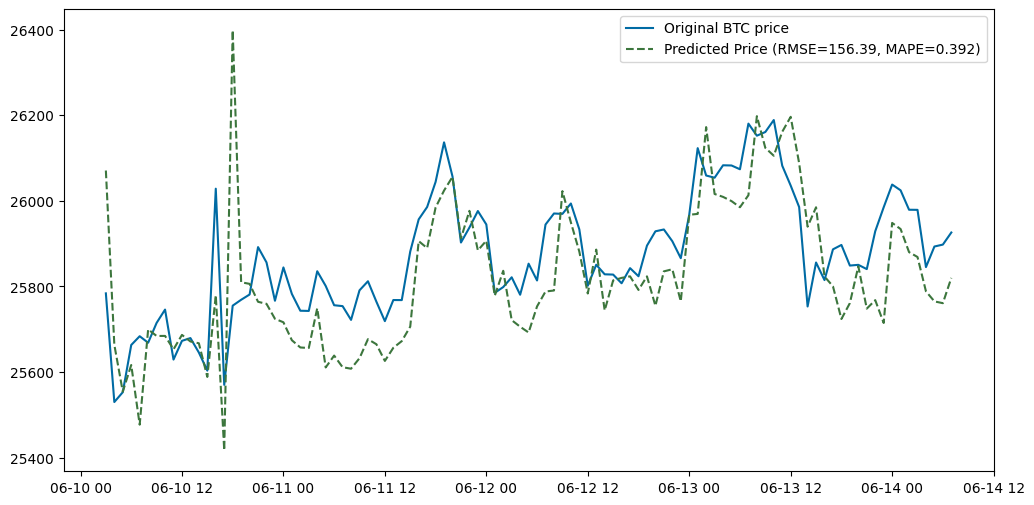

In [177]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

##### LSTM

In [229]:
def create_lstm(units = 24, input_shape = (8, 1), optimizer = Adam()):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        LSTM_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        LSTM_model.add(LSTM(units = units, input_shape = input_shape, return_sequences = False, 
                            kernel_initializer = 'he_uniform', bias_initializer = 'zeros'))
        LSTM_model.add(Dense(1, activation = 'linear'))

        # Compile the model with optimizer and loss function
        LSTM_model.compile(optimizer = optimizer, loss = 'mse')
    return LSTM_model

In [230]:
LSTM_model1 = create_lstm(units = 24, input_shape = (8, 1), optimizer = Adam())
LSTM_model2 = create_lstm(units = 10, input_shape = (1, 1), optimizer = Adam())

# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

In [181]:
predicted_value, rmse_error, mdape_error = hybrid_dl(LSTM_model1, LSTM_model2, batch_size = 32,
                                                     callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 7s 21ms/step - loss: 0.1255 - val_loss: 0.3285 - lr: 0.0010
Epoch 2/500
207/207 [==============================] - 3s 16ms/step - loss: 0.0600 - val_loss: 0.1516 - lr: 0.0010
Epoch 3/500
207/207 [==============================] - 3s 16ms/step - loss: 0.0291 - val_loss: 0.0736 - lr: 0.0010
Epoch 4/500
207/207 [==============================] - 3s 16ms/step - loss: 0.0155 - val_loss: 0.0409 - lr: 0.0010
Epoch 5/500
207/207 [==============================] - 3s 16ms/step - loss: 0.0091 - val_loss: 0.0277 - lr: 0.0010
Epoch 6/500
207/207 [==============================] - 3s 16ms/step - loss: 0.0059 - val_loss: 0.0218 - lr: 0.0010
Epoch 7/500
207/207 [==============================] - 3s 16ms/step - loss: 0.0043 - val_loss: 0.0187 - lr: 0.0010
Epoch 8/500
207/207 [==============================] - 3s 15ms/step - loss: 0.0033 - val_loss: 0.0167 - lr: 0.0010
Epoch 9/500
207/207 [==============================] - 3s 16ms/step - loss: 0.00

207/207 [==============================] - 3s 15ms/step - loss: 14521.8389 - val_loss: 132589.2656 - lr: 0.0010
Epoch 99/700
207/207 [==============================] - 3s 15ms/step - loss: 14509.6826 - val_loss: 132583.7969 - lr: 0.0010
Epoch 100/700
207/207 [==============================] - 3s 14ms/step - loss: 14497.6016 - val_loss: 132578.3125 - lr: 0.0010
Epoch 101/700
207/207 [==============================] - 3s 14ms/step - loss: 14485.6045 - val_loss: 132572.8281 - lr: 0.0010
Epoch 102/700
207/207 [==============================] - 3s 14ms/step - loss: 14473.6963 - val_loss: 132567.3125 - lr: 0.0010
Epoch 103/700
207/207 [==============================] - 3s 14ms/step - loss: 14461.8496 - val_loss: 132561.7969 - lr: 0.0010
Epoch 104/700
207/207 [==============================] - 3s 14ms/step - loss: 14450.0898 - val_loss: 132556.2812 - lr: 0.0010
Epoch 105/700
207/207 [==============================] - 3s 15ms/step - loss: 14438.4033 - val_loss: 132550.7344 - lr: 0.0010
Epoch 1

207/207 [==============================] - 3s 14ms/step - loss: 13347.8418 - val_loss: 131924.5156 - lr: 0.0010
Epoch 229/700
207/207 [==============================] - 3s 14ms/step - loss: 13341.1836 - val_loss: 131921.8281 - lr: 0.0010
Epoch 230/700
207/207 [==============================] - 3s 14ms/step - loss: 13334.5508 - val_loss: 131919.1250 - lr: 0.0010
Epoch 231/700
207/207 [==============================] - 3s 15ms/step - loss: 13327.9541 - val_loss: 131916.4844 - lr: 0.0010
Epoch 232/700
207/207 [==============================] - 3s 14ms/step - loss: 13321.3818 - val_loss: 131913.8750 - lr: 0.0010
Epoch 233/700
207/207 [==============================] - 3s 14ms/step - loss: 13314.8467 - val_loss: 131911.3438 - lr: 0.0010
Epoch 234/700
207/207 [==============================] - 3s 15ms/step - loss: 13308.3350 - val_loss: 131908.7500 - lr: 0.0010
Epoch 235/700
207/207 [==============================] - 3s 14ms/step - loss: 13301.8555 - val_loss: 131906.2344 - lr: 0.0010
Epoch 

207/207 [==============================] - 3s 14ms/step - loss: 12686.2471 - val_loss: 131736.8750 - lr: 0.0010
Epoch 359/700
207/207 [==============================] - 3s 13ms/step - loss: 12682.4131 - val_loss: 131735.6406 - lr: 0.0010
Epoch 360/700
207/207 [==============================] - 3s 14ms/step - loss: 12678.5908 - val_loss: 131734.3906 - lr: 0.0010
Epoch 361/700
207/207 [==============================] - 3s 14ms/step - loss: 12674.7861 - val_loss: 131733.1875 - lr: 0.0010
Epoch 362/700
207/207 [==============================] - 3s 14ms/step - loss: 12670.9912 - val_loss: 131731.9688 - lr: 0.0010
Epoch 363/700
207/207 [==============================] - 3s 14ms/step - loss: 12667.2168 - val_loss: 131730.7344 - lr: 0.0010
Epoch 364/700
207/207 [==============================] - 3s 14ms/step - loss: 12663.4482 - val_loss: 131729.5000 - lr: 0.0010
Epoch 365/700
207/207 [==============================] - 3s 14ms/step - loss: 12659.6982 - val_loss: 131728.2344 - lr: 0.0010
Epoch 

207/207 [==============================] - 3s 14ms/step - loss: 12281.8936 - val_loss: 131515.0312 - lr: 0.0010
Epoch 489/700
207/207 [==============================] - 3s 14ms/step - loss: 12279.3701 - val_loss: 131513.0000 - lr: 0.0010
Epoch 490/700
207/207 [==============================] - 3s 14ms/step - loss: 12276.8574 - val_loss: 131511.0000 - lr: 0.0010
Epoch 491/700
207/207 [==============================] - 3s 14ms/step - loss: 12274.3506 - val_loss: 131508.9844 - lr: 0.0010
Epoch 492/700
207/207 [==============================] - 3s 14ms/step - loss: 12271.8545 - val_loss: 131507.0000 - lr: 0.0010
Epoch 493/700
207/207 [==============================] - 3s 14ms/step - loss: 12269.3604 - val_loss: 131504.9375 - lr: 0.0010
Epoch 494/700
207/207 [==============================] - 3s 14ms/step - loss: 12266.8809 - val_loss: 131502.9219 - lr: 0.0010
Epoch 495/700
207/207 [==============================] - 3s 14ms/step - loss: 12264.3984 - val_loss: 131500.8750 - lr: 0.0010
Epoch 

207/207 [==============================] - 3s 14ms/step - loss: 12005.0215 - val_loss: 131261.6094 - lr: 0.0010
Epoch 619/700
207/207 [==============================] - 3s 14ms/step - loss: 12003.2314 - val_loss: 131259.8125 - lr: 0.0010
Epoch 620/700
207/207 [==============================] - 2s 8ms/step - loss: 12001.4424 - val_loss: 131257.9531 - lr: 0.0010
Epoch 621/700
207/207 [==============================] - 2s 8ms/step - loss: 11999.6631 - val_loss: 131256.1250 - lr: 0.0010
Epoch 622/700
207/207 [==============================] - 2s 11ms/step - loss: 11997.8838 - val_loss: 131254.3281 - lr: 0.0010
Epoch 623/700
207/207 [==============================] - 3s 15ms/step - loss: 11996.1055 - val_loss: 131252.5469 - lr: 0.0010
Epoch 624/700
207/207 [==============================] - 3s 14ms/step - loss: 11994.3389 - val_loss: 131250.7188 - lr: 0.0010
Epoch 625/700
207/207 [==============================] - 3s 14ms/step - loss: 11992.5723 - val_loss: 131248.9219 - lr: 0.0010
Epoch 62

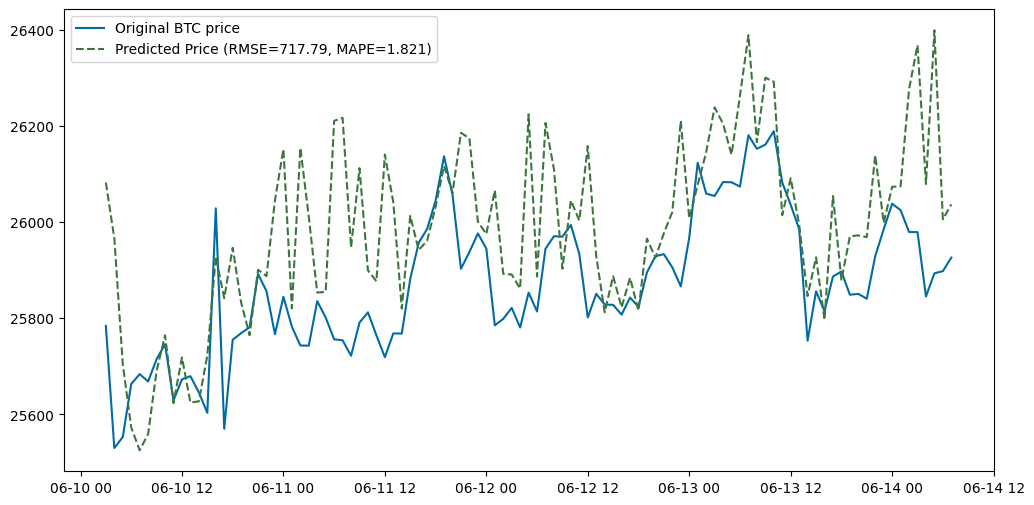

In [182]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

##### CNN-LSTM

In [255]:
trend_X_train.shape

(8259, 8)

In [256]:
trend_X_train = trend_X_train.values.reshape(trend_X_train.shape[0], 1, trend_X_train.shape[1], 1)
trend_X_test = trend_X_test.values.reshape(trend_X_test.shape[0], 1, trend_X_test.shape[1],  1)

In [257]:
# resid_X_train = resid_X_train.values.reshape(resid_X_train.shape[0], 1, resid_X_train.shape[1], 1)
# resid_X_test = resid_X_test.values.reshape(resid_X_test.shape[0], 1, resid_X_test.shape[1], 1)
# seasonal_X_train = seasonal_X_train.reshape(-1, 1)
# seasonal_X_test = seasonal_X_test.reshape(-1, 1)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

In [258]:
def create_cnn_lstm(filters = 32, kernel_size = 1, input_shape=(None, 19, 1), lstm_units = 19,
                    optimizer = SGD(learning_rate = 0.1), pooling = True):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        CNN_LSTM_model = tf.keras.models.Sequential()

        CNN_LSTM_model.add(TimeDistributed(Conv1D(filters = filters, kernel_size = kernel_size, activation='relu'),
                                           input_shape = input_shape))
        if pooling == True:
            CNN_LSTM_model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
        CNN_LSTM_model.add(TimeDistributed(Flatten()))
        # Add a hidden layer with input dimensions, neurons and activation function

        CNN_LSTM_model.add(LSTM(units = lstm_units, kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                            activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
        CNN_LSTM_model.add(Dropout(rate = 0))
        # Add output layer with one 1 ouput neuron as this is regression problem
        CNN_LSTM_model.add(Dense(1, activation = 'linear'))
        CNN_LSTM_model.summary()

        # Compile the model with optimizer and loss function
        CNN_LSTM_model.compile(optimizer = optimizer, loss = 'mse')
    return CNN_LSTM_model

In [311]:
cnn_lstm1 = create_cnn_lstm(filters = 64, kernel_size = 3, input_shape = (None, 8, 1), lstm_units = 8,
                            optimizer = Adam(), pooling = True)

ANN_model = create_ann(units = 4, input_dim = 1, optimizer = Adam(learning_rate = 0.0001))
    
# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_90 (TimeDi  (None, None, 6, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_91 (TimeDi  (None, None, 3, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_92 (TimeDi  (None, None, 192)        0         
 stributed)                                                      
                                                                 
 lstm_43 (LSTM)              (None, 8)                 6432      
                                                                 
 dropout_31 (Dropout)        (None, 8)                 0         
                                                     

In [312]:
predicted_value, rmse_error, mdape_error = hybrid_dl(cnn_lstm1, ANN_model, batch_size = 32,
                                                     callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 3s 10ms/step - loss: 0.0751 - val_loss: 0.0418 - lr: 0.0010
Epoch 2/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0188 - val_loss: 0.0243 - lr: 0.0010
Epoch 3/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0047 - val_loss: 0.0156 - lr: 0.0010
Epoch 4/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0120 - lr: 0.0010
Epoch 5/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0095 - lr: 0.0010
Epoch 6/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0030 - val_loss: 0.0080 - lr: 0.0010
Epoch 7/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0068 - lr: 0.0010
Epoch 8/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0032 - val_loss: 0.0061 - lr: 0.0010
Epoch 9/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0034 - val

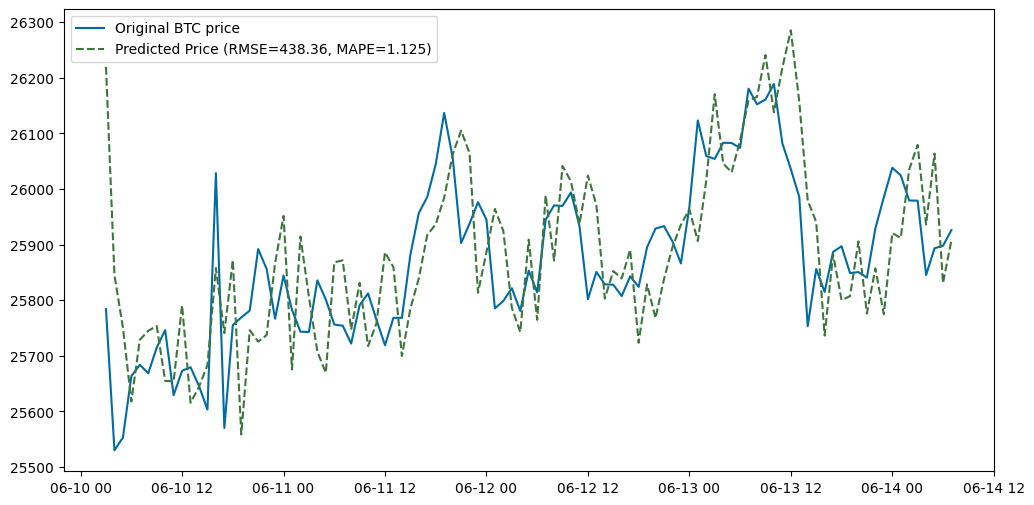

In [313]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

##### ML-DL hybrid

In [314]:
def hybrid_dl_ml(model1, model2, batch_size = 16, callbacks = [callback, REDUCE_LR]):
    history = model1.fit(trend_X_train, y_train, epochs = 500, batch_size = batch_size, validation_split = 0.2, shuffle = False,
                        callbacks = callbacks)
    y_fit = model1.predict(trend_X_train)
    y_pred = model1.predict(trend_X_test)
    
    y_pred = y_enc.inverse_transform(y_pred)
    y_fit = y_enc.inverse_transform(y_fit)

    y_resid = y_train_original - y_fit

    model2.fit(resid_X_train, y_resid)
    y_pred_boosted = model2.predict(resid_X_test).reshape(-1, 1) + y_pred.reshape(-1, 1) + seasonal_X_test
    
    return y_pred_boosted, rmse(y_test_original, y_pred_boosted), float(MAPE(y_test_original.values, y_pred_boosted.values))

In [315]:
regressor1 = LinearRegression()
regressor2 = Ridge()
svr = SVR()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
voting = VotingRegressor([('LR', regressor1), ('Ridge', regressor2), ('svr', svr), ('KNN', knn), ('dt', dt), ('rf', rf),
                          ('gb', gb), ('xgb', xgb)])

In [339]:
cnn_lstm = create_cnn_lstm(filters = 64, kernel_size = 4, input_shape = (None, 8, 1), lstm_units = 8,
                            optimizer = Adam(learning_rate = 0.0001), pooling = True)

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_117 (TimeD  (None, None, 5, 64)      320       
 istributed)                                                     
                                                                 
 time_distributed_118 (TimeD  (None, None, 2, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_119 (TimeD  (None, None, 128)        0         
 istributed)                                                     
                                                                 
 lstm_52 (LSTM)              (None, 8)                 4384      
                                                                 
 dropout_40 (Dropout)        (None, 8)                 0         
                                                    

In [340]:
predicted_value, rmse_error, mdape_error = hybrid_dl_ml(cnn_lstm, regressor2, batch_size = 32,
                                                     callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 3s 10ms/step - loss: 0.2754 - val_loss: 1.4343 - lr: 1.0000e-04
Epoch 2/500
207/207 [==============================] - 2s 9ms/step - loss: 0.2192 - val_loss: 1.2864 - lr: 1.0000e-04
Epoch 3/500
207/207 [==============================] - 2s 9ms/step - loss: 0.1632 - val_loss: 1.0976 - lr: 1.0000e-04
Epoch 4/500
207/207 [==============================] - 2s 9ms/step - loss: 0.1049 - val_loss: 0.8448 - lr: 1.0000e-04
Epoch 5/500
207/207 [==============================] - 2s 9ms/step - loss: 0.0581 - val_loss: 0.5637 - lr: 1.0000e-04
Epoch 6/500
207/207 [==============================] - 2s 9ms/step - loss: 0.0310 - val_loss: 0.3324 - lr: 1.0000e-04
Epoch 7/500
207/207 [==============================] - 2s 9ms/step - loss: 0.0178 - val_loss: 0.1849 - lr: 1.0000e-04
Epoch 8/500
207/207 [==============================] - 2s 9ms/step - loss: 0.0114 - val_loss: 0.1032 - lr: 1.0000e-04
Epoch 9/500
207/207 [==============================] - 

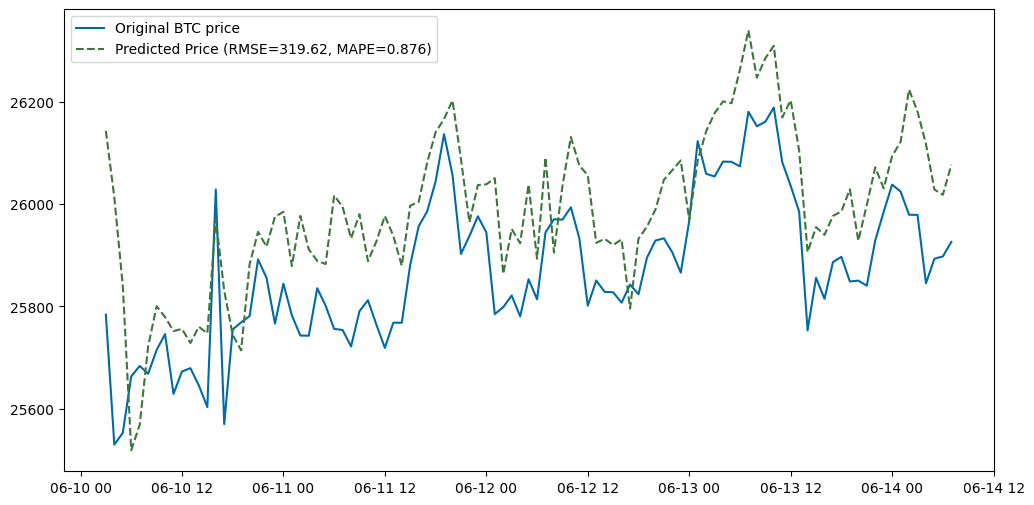

In [341]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

##### With base features and sentiments

In [343]:
#trend = new_df.drop(['seasonal', 'resid', 'close'], axis = 1)
trend = new_df[['high', 'low', 'open', 'volumefrom', 'volumeto', 'hourly_volume', 'hourly_return', 'trend_score',
                'Compound_score', 'Polarity', 'trend']]
seasonal = new_df[['seasonal']]
resid = new_df[['resid']]
y = new_df[['close']]

trend_X_train, trend_X_test, y_train, y_test = train_test_split(trend, y, test_size = 500, shuffle = False)
resid_X_train, resid_X_test = train_test_split(resid, test_size = 500, shuffle = False)
seasonal_X_train, seasonal_X_test = train_test_split(seasonal, test_size = 500, shuffle = False)

In [344]:
trend_X_train.shape, trend_X_test.shape, y_train.shape, y_test.shape, resid_X_train.shape, resid_X_test.shape, seasonal_X_train.shape, seasonal_X_test.shape

((8259, 11),
 (500, 11),
 (8259, 1),
 (500, 1),
 (8259, 1),
 (500, 1),
 (8259, 1),
 (500, 1))

In [345]:
# trend_X_train = trend_X_train.reshape(-1, 1)
# trend_X_test = trend_X_test.reshape(-1, 1)
# resid_X_train = resid_X_train.reshape(-1, 1)
# resid_X_test = resid_X_test.reshape(-1, 1)
# seasonal_X_train = seasonal_X_train.reshape(-1, 1)
# seasonal_X_test = seasonal_X_test.reshape(-1, 1)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

In [346]:
# trend_X_train.shape, trend_X_test.shape, y_train.shape, y_test.shape, resid_X_train.shape, resid_X_test.shape, seasonal_X_train.shape, seasonal_X_test.shape

In [347]:
# Functions for transformation
y_train_original = y_train.copy()
y_test_original = y_test.copy()

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

cols1 = trend_X_train.columns
trend_enc = RobustScaler()
trend_X_train[cols1] = trend_enc.fit_transform(trend_X_train[cols1])
trend_X_test[cols1] = trend_enc.transform(trend_X_test[cols1])

cols2 = y_train.columns
y_enc = RobustScaler()
y_train[cols2] = y_enc.fit_transform(y_train[cols2])
y_test[cols2] = y_enc.transform(y_test[cols2])

##### Search for model combination

In [362]:
model_list = [regressor1, regressor2, svr, knn, dt, rf, gb, xgb, voting]
error_list = []
combination = []

for i in model_list:
    for j in model_list:
        print('Iteration started: ', str(len(error_list) + 1))
        #print('Training started with: ', i, ', ', j)
        point1, rmse_error, mdape_error = hybrid(i, j)
        error_list.append(rmse_error)
        combination.append([i, j])
        
ind = error_list.index(min(error_list))
best_combo = combination[ind]
print("==========Hybrid Model Combination search result==========")
print("Best error: ", str(error_list[ind]), ', with combination: ', best_combo)

Iteration started:  1
Iteration started:  2
Iteration started:  3
Iteration started:  4
Iteration started:  5
Iteration started:  6
Iteration started:  7
Iteration started:  8
Iteration started:  9
Iteration started:  10
Iteration started:  11
Iteration started:  12
Iteration started:  13
Iteration started:  14
Iteration started:  15
Iteration started:  16
Iteration started:  17
Iteration started:  18
Iteration started:  19
Iteration started:  20
Iteration started:  21
Iteration started:  22
Iteration started:  23
Iteration started:  24
Iteration started:  25
Iteration started:  26
Iteration started:  27
Iteration started:  28
Iteration started:  29
Iteration started:  30
Iteration started:  31
Iteration started:  32
Iteration started:  33
Iteration started:  34
Iteration started:  35
Iteration started:  36
Iteration started:  37
Iteration started:  38
Iteration started:  39
Iteration started:  40
Iteration started:  41
Iteration started:  42
Iteration started:  43
Iteration started:  

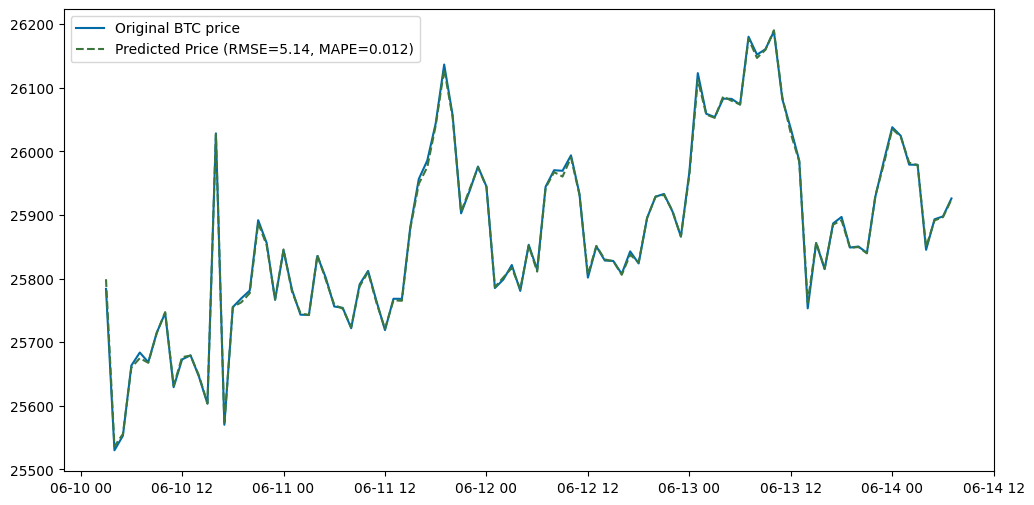

In [364]:
predicted_value, rmse_error, mdape_error = hybrid(LinearRegression(), SVR())

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

### Deep learning

##### ANN

In [365]:
ANN_model1 = create_ann(units = 44, input_dim = 11, optimizer = RMSprop(learning_rate = 0.0001))
ANN_model2 = create_ann(units = 10, input_dim = 1, optimizer = RMSprop(learning_rate = 0.0001))

# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

In [366]:
predicted_value, rmse_error, mdape_error = hybrid_dl(ANN_model1, ANN_model2, batch_size = 32, callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 1s 5ms/step - loss: 0.2752 - val_loss: 0.9825 - lr: 1.0000e-04
Epoch 2/500
207/207 [==============================] - 1s 4ms/step - loss: 0.1314 - val_loss: 0.5836 - lr: 1.0000e-04
Epoch 3/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0647 - val_loss: 0.2787 - lr: 1.0000e-04
Epoch 4/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0380 - val_loss: 0.1017 - lr: 1.0000e-04
Epoch 5/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0261 - val_loss: 0.0288 - lr: 1.0000e-04
Epoch 6/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0188 - val_loss: 0.0094 - lr: 1.0000e-04
Epoch 7/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0133 - val_loss: 0.0059 - lr: 1.0000e-04
Epoch 8/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 0.0053 - lr: 1.0000e-04
Epoch 9/500
207/207 [==============================] - 1

Epoch 29/500
207/207 [==============================] - 1s 4ms/step - loss: 32057.0586 - val_loss: 48254.6211 - lr: 1.0000e-04
Epoch 30/500
207/207 [==============================] - 1s 4ms/step - loss: 31987.4219 - val_loss: 48104.1875 - lr: 1.0000e-04
Epoch 31/500
207/207 [==============================] - 1s 4ms/step - loss: 31919.8691 - val_loss: 47960.3359 - lr: 1.0000e-04
Epoch 32/500
207/207 [==============================] - 1s 4ms/step - loss: 31854.2500 - val_loss: 47822.8945 - lr: 1.0000e-04
Epoch 33/500
207/207 [==============================] - 1s 4ms/step - loss: 31791.0078 - val_loss: 47696.5000 - lr: 1.0000e-04
Epoch 34/500
207/207 [==============================] - 1s 4ms/step - loss: 31730.4805 - val_loss: 47579.8125 - lr: 1.0000e-04
Epoch 35/500
207/207 [==============================] - 1s 4ms/step - loss: 31671.8359 - val_loss: 47468.2070 - lr: 1.0000e-04
Epoch 36/500
207/207 [==============================] - 1s 4ms/step - loss: 31614.8984 - val_loss: 47361.3164 -

In [367]:
float(rmse(y_test_original.values, predicted_value.values))

220.78732612360403

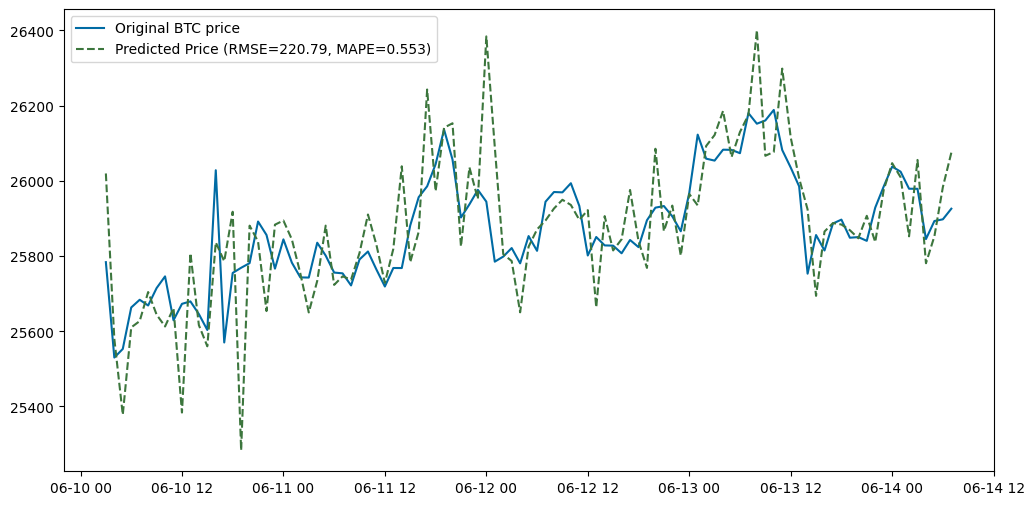

In [368]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

##### LSTM

In [369]:
LSTM_model1 = create_lstm(units = 33, input_shape = (11, 1), optimizer = Adam())
LSTM_model2 = create_lstm(units = 10, input_shape = (1, 1), optimizer = Adam())

# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

In [370]:
predicted_value, rmse_error, mdape_error = hybrid_dl(LSTM_model1, LSTM_model2, batch_size = 32,
                                                     callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 3s 10ms/step - loss: 0.0266 - val_loss: 0.0317 - lr: 0.0010
Epoch 2/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0103 - val_loss: 0.0181 - lr: 0.0010
Epoch 3/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0061 - val_loss: 0.0154 - lr: 0.0010
Epoch 4/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0046 - val_loss: 0.0133 - lr: 0.0010
Epoch 5/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0117 - lr: 0.0010
Epoch 6/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0027 - val_loss: 0.0104 - lr: 0.0010
Epoch 7/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0022 - val_loss: 0.0093 - lr: 0.0010
Epoch 8/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0018 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0015 - val

Epoch 89/500
207/207 [==============================] - 1s 6ms/step - loss: 10598.7236 - val_loss: 57331.7734 - lr: 0.0010
Epoch 90/500
207/207 [==============================] - 1s 6ms/step - loss: 10588.3320 - val_loss: 57315.1133 - lr: 0.0010
Epoch 91/500
207/207 [==============================] - 1s 6ms/step - loss: 10578.0244 - val_loss: 57298.5703 - lr: 0.0010
Epoch 92/500
207/207 [==============================] - 1s 7ms/step - loss: 10567.7891 - val_loss: 57282.1836 - lr: 0.0010
Epoch 93/500
207/207 [==============================] - 1s 6ms/step - loss: 10557.6240 - val_loss: 57265.9062 - lr: 0.0010
Epoch 94/500
207/207 [==============================] - 1s 6ms/step - loss: 10547.5352 - val_loss: 57249.8008 - lr: 0.0010
Epoch 95/500
207/207 [==============================] - 1s 6ms/step - loss: 10537.5156 - val_loss: 57233.8242 - lr: 0.0010
Epoch 96/500
207/207 [==============================] - 1s 6ms/step - loss: 10527.5703 - val_loss: 57217.9648 - lr: 0.0010
Epoch 97/500
207

207/207 [==============================] - 1s 6ms/step - loss: 9663.5947 - val_loss: 56028.8555 - lr: 0.0010
Epoch 222/500
207/207 [==============================] - 1s 6ms/step - loss: 9658.8477 - val_loss: 56023.0352 - lr: 0.0010
Epoch 223/500
207/207 [==============================] - 1s 6ms/step - loss: 9654.1299 - val_loss: 56017.2656 - lr: 0.0010
Epoch 224/500
207/207 [==============================] - 1s 6ms/step - loss: 9649.4385 - val_loss: 56011.5312 - lr: 0.0010
Epoch 225/500
207/207 [==============================] - 1s 6ms/step - loss: 9644.7666 - val_loss: 56005.8320 - lr: 0.0010
Epoch 226/500
207/207 [==============================] - 1s 6ms/step - loss: 9640.1172 - val_loss: 56000.1406 - lr: 0.0010
Epoch 227/500
207/207 [==============================] - 1s 7ms/step - loss: 9635.4932 - val_loss: 55994.5117 - lr: 0.0010
Epoch 228/500
207/207 [==============================] - 1s 6ms/step - loss: 9630.8955 - val_loss: 55988.9141 - lr: 0.0010
Epoch 229/500
207/207 [=======

Epoch 288/500
207/207 [==============================] - 1s 6ms/step - loss: 9393.3975 - val_loss: 55705.7617 - lr: 0.0010
Epoch 289/500
207/207 [==============================] - 1s 6ms/step - loss: 9389.9932 - val_loss: 55701.7578 - lr: 0.0010
Epoch 290/500
207/207 [==============================] - 1s 7ms/step - loss: 9386.6162 - val_loss: 55697.7812 - lr: 0.0010
Epoch 291/500
207/207 [==============================] - 1s 6ms/step - loss: 9383.2471 - val_loss: 55693.8125 - lr: 0.0010
Epoch 292/500
207/207 [==============================] - 1s 6ms/step - loss: 9379.8955 - val_loss: 55689.8867 - lr: 0.0010
Epoch 293/500
207/207 [==============================] - 1s 6ms/step - loss: 9376.5605 - val_loss: 55685.9453 - lr: 0.0010
Epoch 294/500
207/207 [==============================] - 1s 6ms/step - loss: 9373.2412 - val_loss: 55682.0469 - lr: 0.0010
Epoch 295/500
207/207 [==============================] - 1s 6ms/step - loss: 9369.9365 - val_loss: 55678.1562 - lr: 0.0010
Epoch 296/500
20

Epoch 421/500
207/207 [==============================] - 1s 6ms/step - loss: 9051.7227 - val_loss: 55293.5273 - lr: 0.0010
Epoch 422/500
207/207 [==============================] - 1s 6ms/step - loss: 9049.8115 - val_loss: 55291.2266 - lr: 0.0010
Epoch 423/500
207/207 [==============================] - 1s 6ms/step - loss: 9047.9072 - val_loss: 55288.9219 - lr: 0.0010
Epoch 424/500
207/207 [==============================] - 1s 6ms/step - loss: 9046.0156 - val_loss: 55286.6523 - lr: 0.0010
Epoch 425/500
207/207 [==============================] - 1s 6ms/step - loss: 9044.1221 - val_loss: 55284.3828 - lr: 0.0010
Epoch 426/500
207/207 [==============================] - 1s 6ms/step - loss: 9042.2383 - val_loss: 55282.1250 - lr: 0.0010
Epoch 427/500
207/207 [==============================] - 1s 6ms/step - loss: 9040.3691 - val_loss: 55279.8633 - lr: 0.0010
Epoch 428/500
207/207 [==============================] - 1s 6ms/step - loss: 9038.5088 - val_loss: 55277.6211 - lr: 0.0010
Epoch 429/500
20

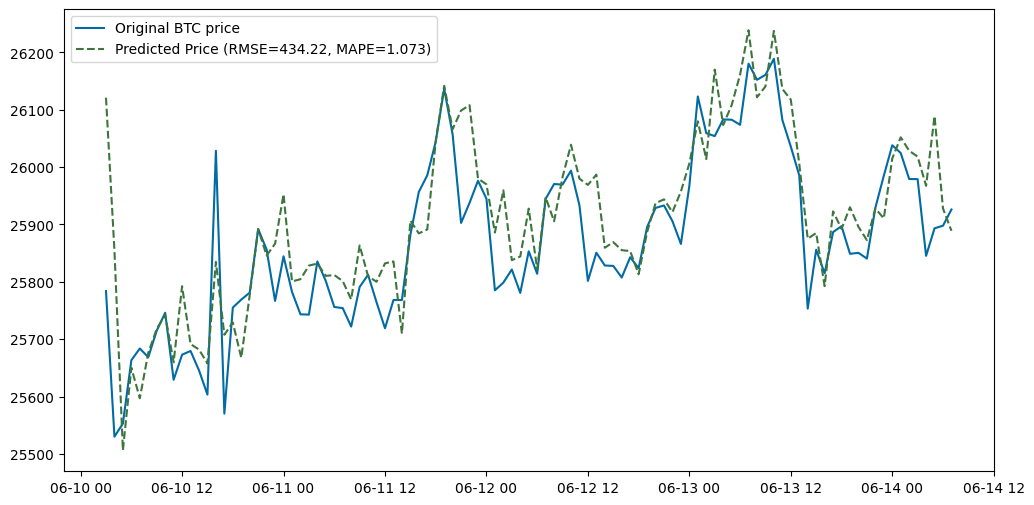

In [372]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_test_original[0:101], label = 'Original BTC price');
ax.plot(predicted_value[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f})".format(rmse_error, mdape_error)); 
ax.legend();
ax.set_title("");

##### CNN-LSTM

In [376]:
trend_X_train.shape

(8259, 1, 11, 1)

In [374]:
trend_X_train = trend_X_train.values.reshape(trend_X_train.shape[0], 1, trend_X_train.shape[1], 1)
trend_X_test = trend_X_test.values.reshape(trend_X_test.shape[0], 1, trend_X_test.shape[1],  1)

In [375]:
# resid_X_train = resid_X_train.values.reshape(resid_X_train.shape[0], 1, resid_X_train.shape[1], 1)
# resid_X_test = resid_X_test.values.reshape(resid_X_test.shape[0], 1, resid_X_test.shape[1], 1)
# seasonal_X_train = seasonal_X_train.reshape(-1, 1)
# seasonal_X_test = seasonal_X_test.reshape(-1, 1)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

In [378]:
cnn_lstm1 = create_cnn_lstm(filters = 64, kernel_size = 3, input_shape = (None, 11, 1), lstm_units = 11,
                            optimizer = Adam(), pooling = True)

ANN_model = create_ann(units = 4, input_dim = 1, optimizer = Adam(learning_rate = 0.0001))
    
# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_120 (TimeD  (None, None, 9, 64)      256       
 istributed)                                                     
                                                                 
 time_distributed_121 (TimeD  (None, None, 4, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (None, None, 256)        0         
 istributed)                                                     
                                                                 
 lstm_55 (LSTM)              (None, 8)                 8480      
                                                                 
 dropout_41 (Dropout)        (None, 8)                 0         
                                                    

In [379]:
predicted_value, rmse_error, mdape_error = hybrid_dl(cnn_lstm1, ANN_model, batch_size = 32,
                                                     callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 5s 8ms/step - loss: 0.0964 - val_loss: 0.1921 - lr: 0.0010
Epoch 2/500
207/207 [==============================] - 1s 6ms/step - loss: 0.0316 - val_loss: 0.0265 - lr: 0.0010
Epoch 3/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0095 - val_loss: 0.0199 - lr: 0.0010
Epoch 4/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0055 - val_loss: 0.0165 - lr: 0.0010
Epoch 5/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0042 - val_loss: 0.0131 - lr: 0.0010
Epoch 6/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0034 - val_loss: 0.0105 - lr: 0.0010
Epoch 7/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0030 - val_loss: 0.0087 - lr: 0.0010
Epoch 8/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0028 - val_loss: 0.0075 - lr: 0.0010
Epoch 9/500
207/207 [==============================] - 2s 8ms/step - loss: 0.0028 - val_

207/207 [==============================] - 2s 8ms/step - loss: 5.6943e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 136/500
207/207 [==============================] - 2s 8ms/step - loss: 5.6931e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 137/500
207/207 [==============================] - 2s 8ms/step - loss: 5.6920e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 138/500
207/207 [==============================] - 2s 8ms/step - loss: 5.6909e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 139/500
207/207 [==============================] - 2s 8ms/step - loss: 5.6897e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 140/500
207/207 [==============================] - 2s 8ms/step - loss: 5.6886e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 141/500
207/207 [==============================] - 2s 8ms/step - loss: 5.6875e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 142/500
207/207 [==============================] - 2s 8ms/step - loss: 5.6863e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 143/500
207/207 

207/207 [==============================] - 2s 8ms/step - loss: 5.5620e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 268/500
207/207 [==============================] - 2s 8ms/step - loss: 5.5611e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 269/500
207/207 [==============================] - 2s 8ms/step - loss: 5.5602e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 270/500
207/207 [==============================] - 2s 8ms/step - loss: 5.5593e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 271/500
207/207 [==============================] - 2s 8ms/step - loss: 5.5585e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 272/500
207/207 [==============================] - 2s 8ms/step - loss: 5.5576e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 273/500
207/207 [==============================] - 2s 8ms/step - loss: 5.5567e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 274/500
207/207 [==============================] - 2s 8ms/step - loss: 5.5558e-04 - val_loss: 0.0025 - lr: 1.0000e-06
Epoch 275/500
207/207 

207/207 [==============================] - 2s 8ms/step - loss: 5.4561e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 400/500
207/207 [==============================] - 2s 8ms/step - loss: 5.4554e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 401/500
207/207 [==============================] - 2s 8ms/step - loss: 5.4547e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 402/500
207/207 [==============================] - 2s 8ms/step - loss: 5.4539e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 403/500
207/207 [==============================] - 2s 8ms/step - loss: 5.4532e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 404/500
207/207 [==============================] - 2s 8ms/step - loss: 5.4525e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 405/500
207/207 [==============================] - 2s 8ms/step - loss: 5.4518e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 406/500
207/207 [==============================] - 2s 8ms/step - loss: 5.4510e-04 - val_loss: 0.0024 - lr: 1.0000e-06
Epoch 407/500
207/207 

Epoch 30/500
207/207 [==============================] - 1s 4ms/step - loss: 12620.6074 - val_loss: 73594.4844 - lr: 1.0000e-04
Epoch 31/500
207/207 [==============================] - 1s 4ms/step - loss: 12537.2422 - val_loss: 73541.2969 - lr: 1.0000e-04
Epoch 32/500
207/207 [==============================] - 1s 4ms/step - loss: 12456.6777 - val_loss: 73491.9141 - lr: 1.0000e-04
Epoch 33/500
207/207 [==============================] - 1s 4ms/step - loss: 12379.0430 - val_loss: 73446.3281 - lr: 1.0000e-04
Epoch 34/500
207/207 [==============================] - 1s 4ms/step - loss: 12304.4287 - val_loss: 73404.5000 - lr: 1.0000e-04
Epoch 35/500
207/207 [==============================] - 1s 5ms/step - loss: 12232.9082 - val_loss: 73366.3984 - lr: 1.0000e-04
Epoch 36/500
207/207 [==============================] - 1s 4ms/step - loss: 12164.5137 - val_loss: 73331.8984 - lr: 1.0000e-04
Epoch 37/500
207/207 [==============================] - 1s 4ms/step - loss: 12099.2725 - val_loss: 73300.9297 -